In [1]:
%matplotlib inline
import json
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.time import Time
from collections import OrderedDict
from datetime import datetime
from tqdm import tqdm

matplotlib.style.use('matplotlibrc')

In [2]:
# Define data paths.
records_path = "records.csv"
authors_path = "authors.json"

records = Table.read(records_path)
# Ignore the dummy line, if it exists.
# (I do this to force arxiv identifiers to be strings. It's not a good idea, in general.)
if records["id"][0] == "dummy":
    records = records[1:]
    
# Let's add some useful columns.
records["created_decimal_year"] = Time(records["created"]).decimalyear

with open(authors_path, "r") as fp:
    authors = json.load(fp)

In [3]:
# Sort ascending by ID, as it will be useful later on.
#records.sort(["id"])

In [4]:
# How we will define a 'unique' author.
def unique_ify(author_name):
    given, last = author_name
    try:
        first_initial = f"{given[0].strip()[:1]}."
    except IndexError:
        return f"{last.strip()}"
    else:
        return f"{last.strip()}, {first_initial}"
    
# Get date (to ~month granularity) from an arxiv ID
get_date = lambda arxiv_id: (int(f"20{arxiv_id[:2]}"), int(arxiv_id[2:4]))

In [5]:
# Build profiles on authors within a given field.
def get_author_profiles(chosen_records, authors):
    author_profiles = {}
    for arxiv_id in chosen_records["id"]:
        for i, author_name in enumerate(map(unique_ify, authors[arxiv_id])):
            author_profiles.setdefault(author_name, [])
            # Here we only store arxiv ID as we can use this to get timing
            # down to ~month granularity without looking up the records
            # table.
            # (and we store the author index)
            author_profiles[author_name].append((arxiv_id, i))
    return author_profiles

In [6]:
# Build field-specific profiles
ppcs = set(records["primary_parent_category"])
profiles = {}
for ppc in ppcs:
    print(ppc)
    mask = (records["primary_parent_category"] == ppc)
    profiles[ppc] = get_author_profiles(
        records[mask],
        authors
    )

cond-mat
math-ph
hep-th
quant-ph
math
cs
q-fin
nlin
q-bio
hep-lat
gr-qc
eess
astro-ph
nucl-ex
physics
nucl-th
econ
stat
hep-ph
hep-ex


In [7]:
primary_parent_category = "astro-ph"
too_many = 350

Text(0, 0.5, '$\\mathrm{Number~of~authors}$')

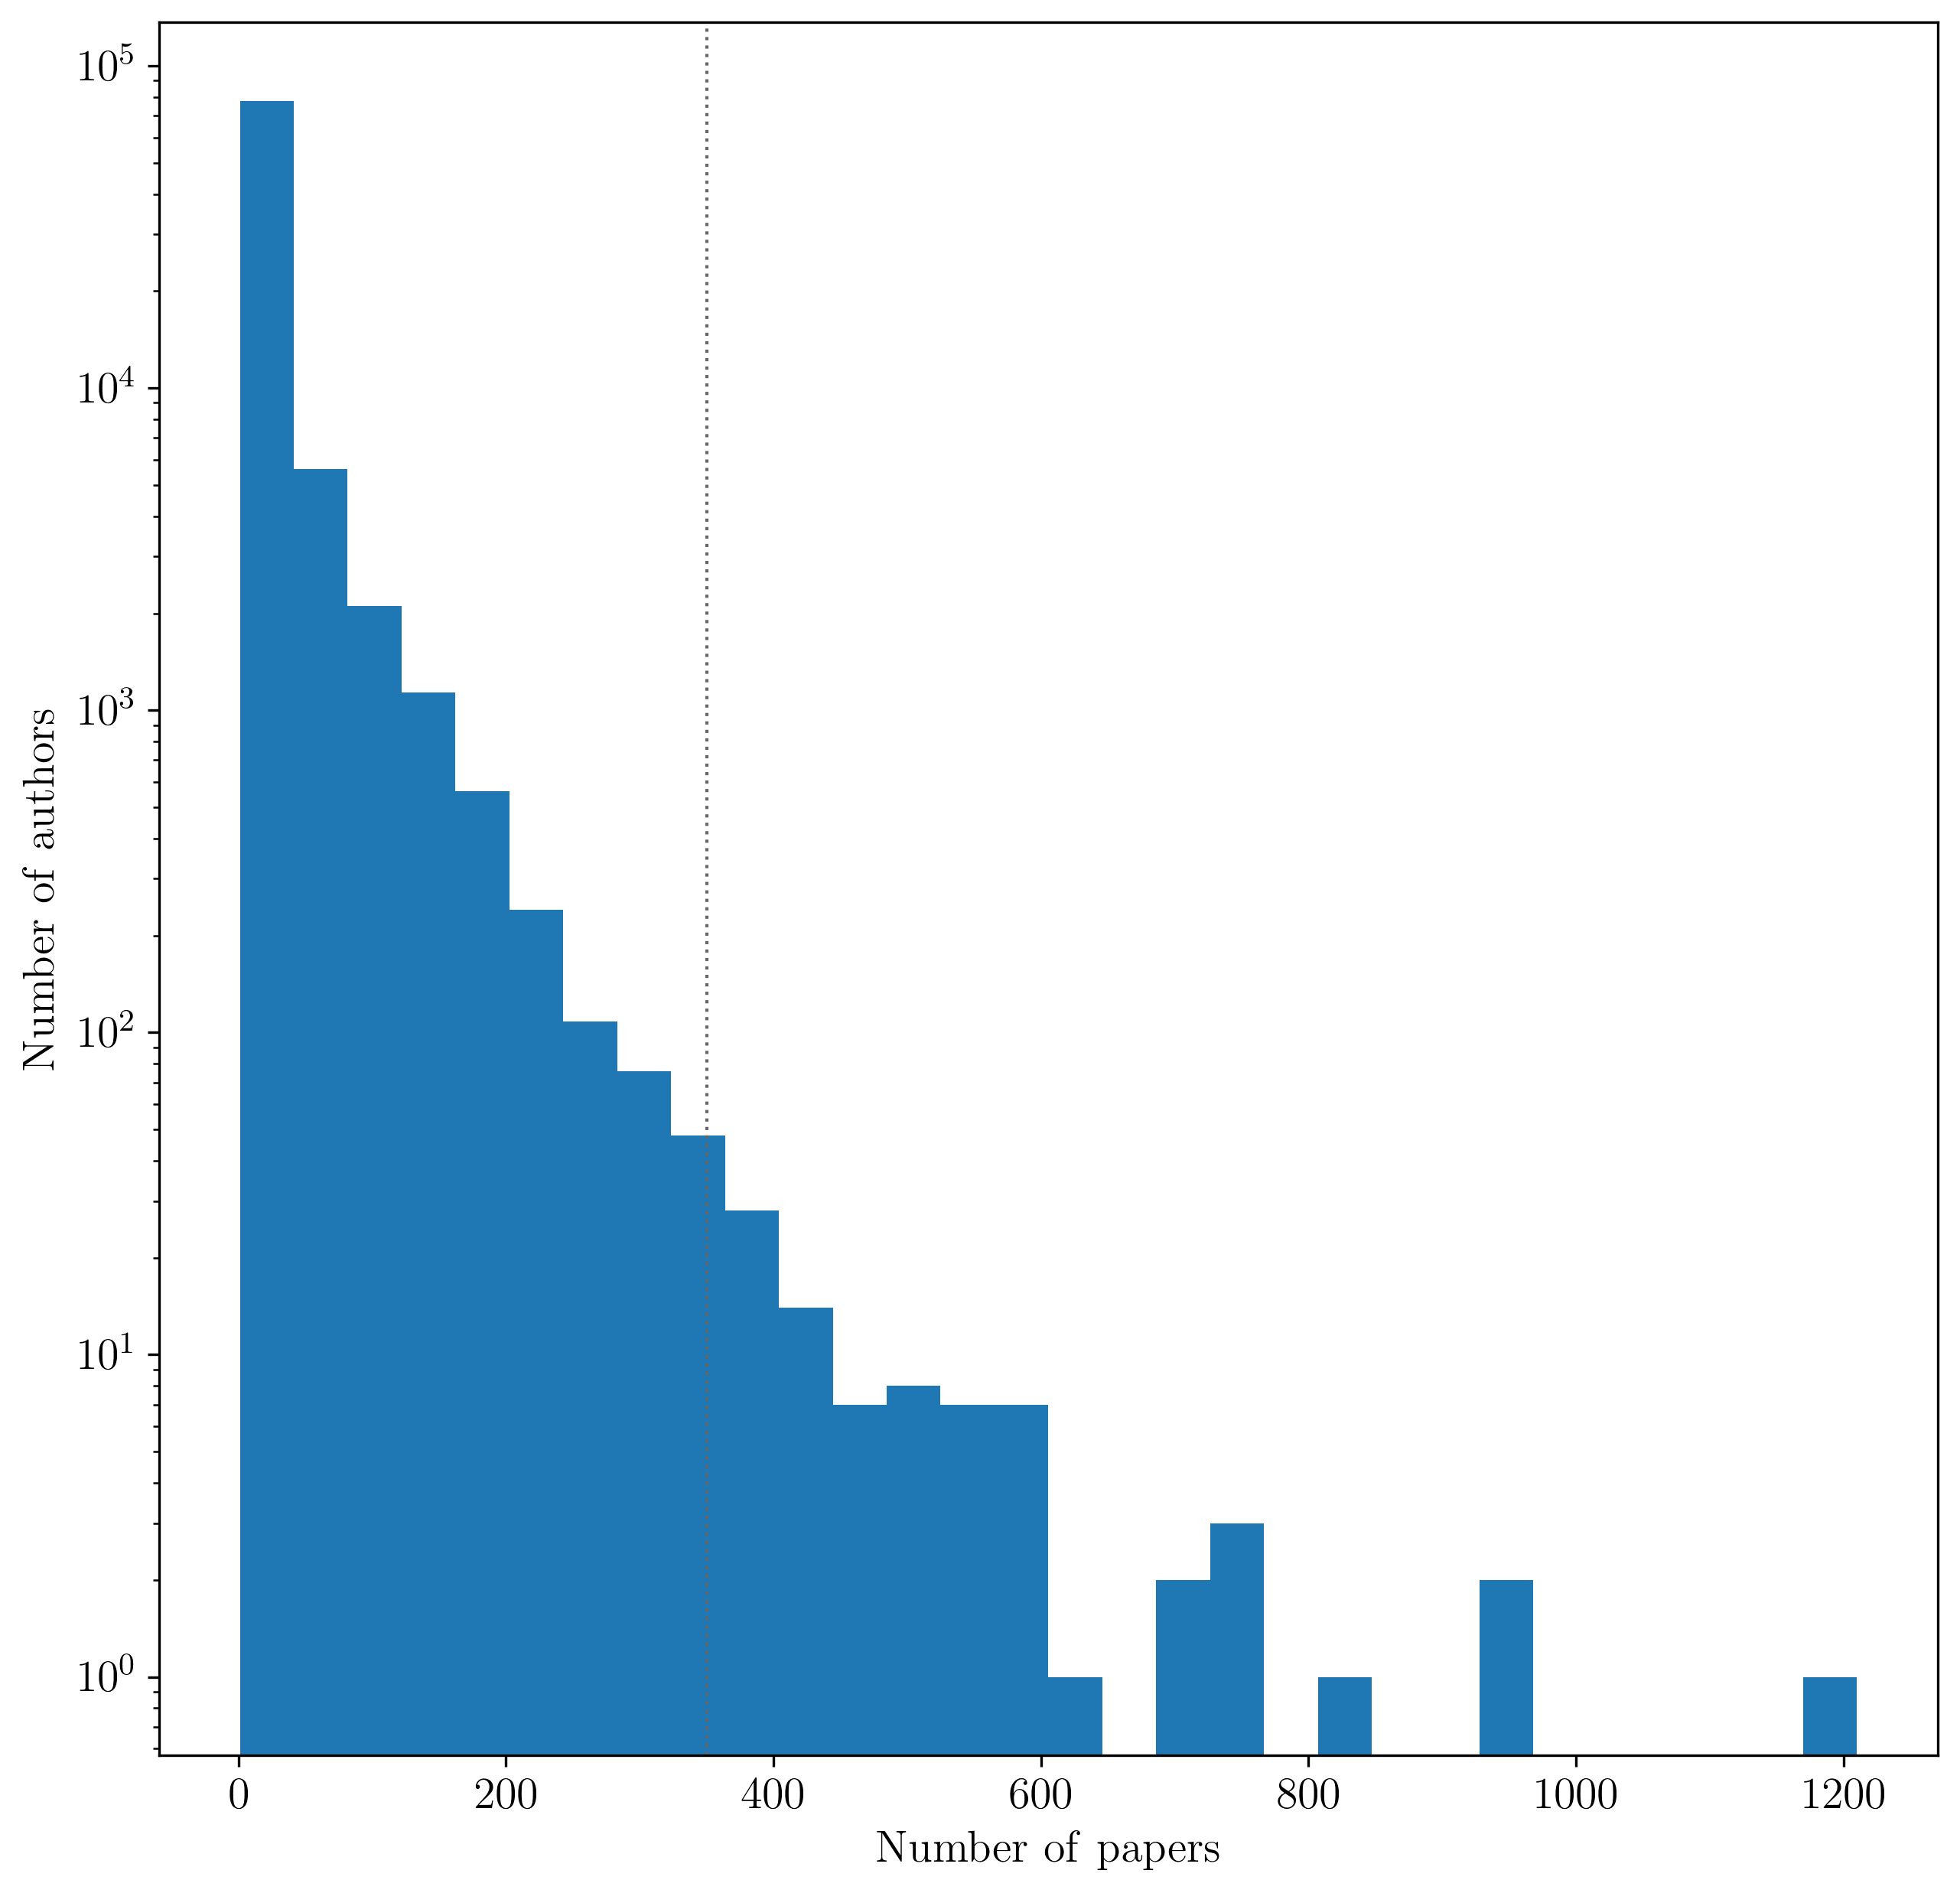

In [8]:
# Histogram the number of papers by 'unique' author so we get an idea of how much name ambiguity matters
X = np.array([len(v) for k, v in profiles[primary_parent_category].items()])
fig, ax = plt.subplots()
ax.hist(X, bins=30, log=True)
ax.axvline(too_many, c="#666666", ls=":", lw=1, zorder=2)
ax.set_xlabel(r"$\mathrm{Number~of~papers}$")
ax.set_ylabel(r"$\mathrm{Number~of~authors}$")


In [9]:
# Make some attempt to remove multiple people grouped together with the same name
common_names = sorted([k for k, v in profiles[primary_parent_category].items() if len(v) >= too_many])
common_names.extend([k for k, v in profiles[primary_parent_category].items() if ("Collaborat" in k or "Team," in k or "," not in k or len(k.split(",")[0]) <= 3)])

In [10]:
def sorter(_):
    year, month = get_date(_[0])
    return year + (month - 1)/12.


def get_cohort(
        profiles, 
        name_first_appears_after,
        first_leading_paper_appears_before,
        min_career_span,
        max_career_span,
        min_first_author_papers=0,
        ignore=None,
    ):
    
    names = []
    for name, profile in tqdm(profiles.items()):
        if len(profile) == 1 or (ignore is not None and name in ignore):
            continue

        sorted_profile = sorted(profile, key=sorter)
        first_pub_date = sorter([sorted_profile[0][0]])
        last_pub_date = sorter([sorted_profile[-1][0]])
            
        first_leading_pub_date = None
        n_first = 0
        for arxiv_id, author_index in sorted_profile:
            if author_index == 0:
                if first_leading_pub_date is None:
                    first_leading_pub_date = sorter([arxiv_id])
                n_first += 1
                
        if min_first_author_papers is not None and min_first_author_papers > n_first:
            continue
            
        if name_first_appears_after is not None:
            if first_pub_date < name_first_appears_after:
                continue
        
        if first_leading_paper_appears_before is not None:
            
            if first_leading_pub_date is None \
            or first_leading_pub_date > first_leading_paper_appears_before \
            or first_leading_pub_date < name_first_appears_after:
                continue

        career_span = last_pub_date - first_pub_date
        if min_career_span is not None and career_span <= min_career_span:
            continue
            
        if max_career_span is not None and career_span > max_career_span:
            continue
                    
        names.append(name)
        
    return names


In [11]:

career_length = 8
min_first_author_papers = 1
name_first_appears_after = 2011
first_leading_paper_appears_before = None


active_names = get_cohort(
    profiles[primary_parent_category],
    name_first_appears_after=name_first_appears_after,
    first_leading_paper_appears_before=first_leading_paper_appears_before,
    min_first_author_papers=min_first_author_papers,
    min_career_span=career_length,
    max_career_span=None,
    ignore=common_names
)
inactive_names = get_cohort(
    profiles[primary_parent_category],
    min_first_author_papers=min_first_author_papers,
    name_first_appears_after=name_first_appears_after,
    first_leading_paper_appears_before=first_leading_paper_appears_before,
    min_career_span=None,
    max_career_span=career_length,
    ignore=common_names
)



100%|██████████| 87608/87608 [00:05<00:00, 14900.63it/s]


In [13]:
print(len(inactive_names))
print(len(active_names))
print(len(common_names))

11618
1596
4061


In [32]:
I = len(inactive_names)
inactive_longevity = np.zeros(I)
inactive_first_author_pubs = np.zeros(I)
inactive_nth_author_pubs = np.zeros(I)

A = len(active_names)
active_longevity = np.zeros(I)
active_first_author_pubs = np.zeros(I)
active_nth_author_pubs = np.zeros(I)

for i, name in enumerate(tqdm(inactive_names)):
    # Get number of publications within first X years.
    
    profile = profiles["astro-ph"][name]
    n_first = sum([(1 if index == 0 else 0) for (arxiv_id, index) in profile])
    n_nth = sum([(1 if index != 0 else 0) for (arxiv_id, index) in profile])
    
    D = np.array([sorter(arxiv_id) for arxiv_id in profile])
    
    inactive_longevity[i] = np.ptp(D)
    inactive_first_author_pubs[i] = n_first
    inactive_nth_author_pubs[i] = n_nth
        
for i, name in enumerate(tqdm(active_names)):
    profile = profiles["astro-ph"][name]
    n_first = sum([(1 if index == 0 else 0) for (arxiv_id, index) in profile])
    n_nth = sum([(1 if index != 0 else 0) for (arxiv_id, index) in profile])
    
    D = np.array([sorter(arxiv_id) for arxiv_id in profile])
    
    active_longevity[i] = np.ptp(D)
    active_first_author_pubs[i] = n_first
    active_nth_author_pubs[i] = n_nth
            
        

100%|██████████| 1596/1596 [00:00<00:00, 16163.76it/s]


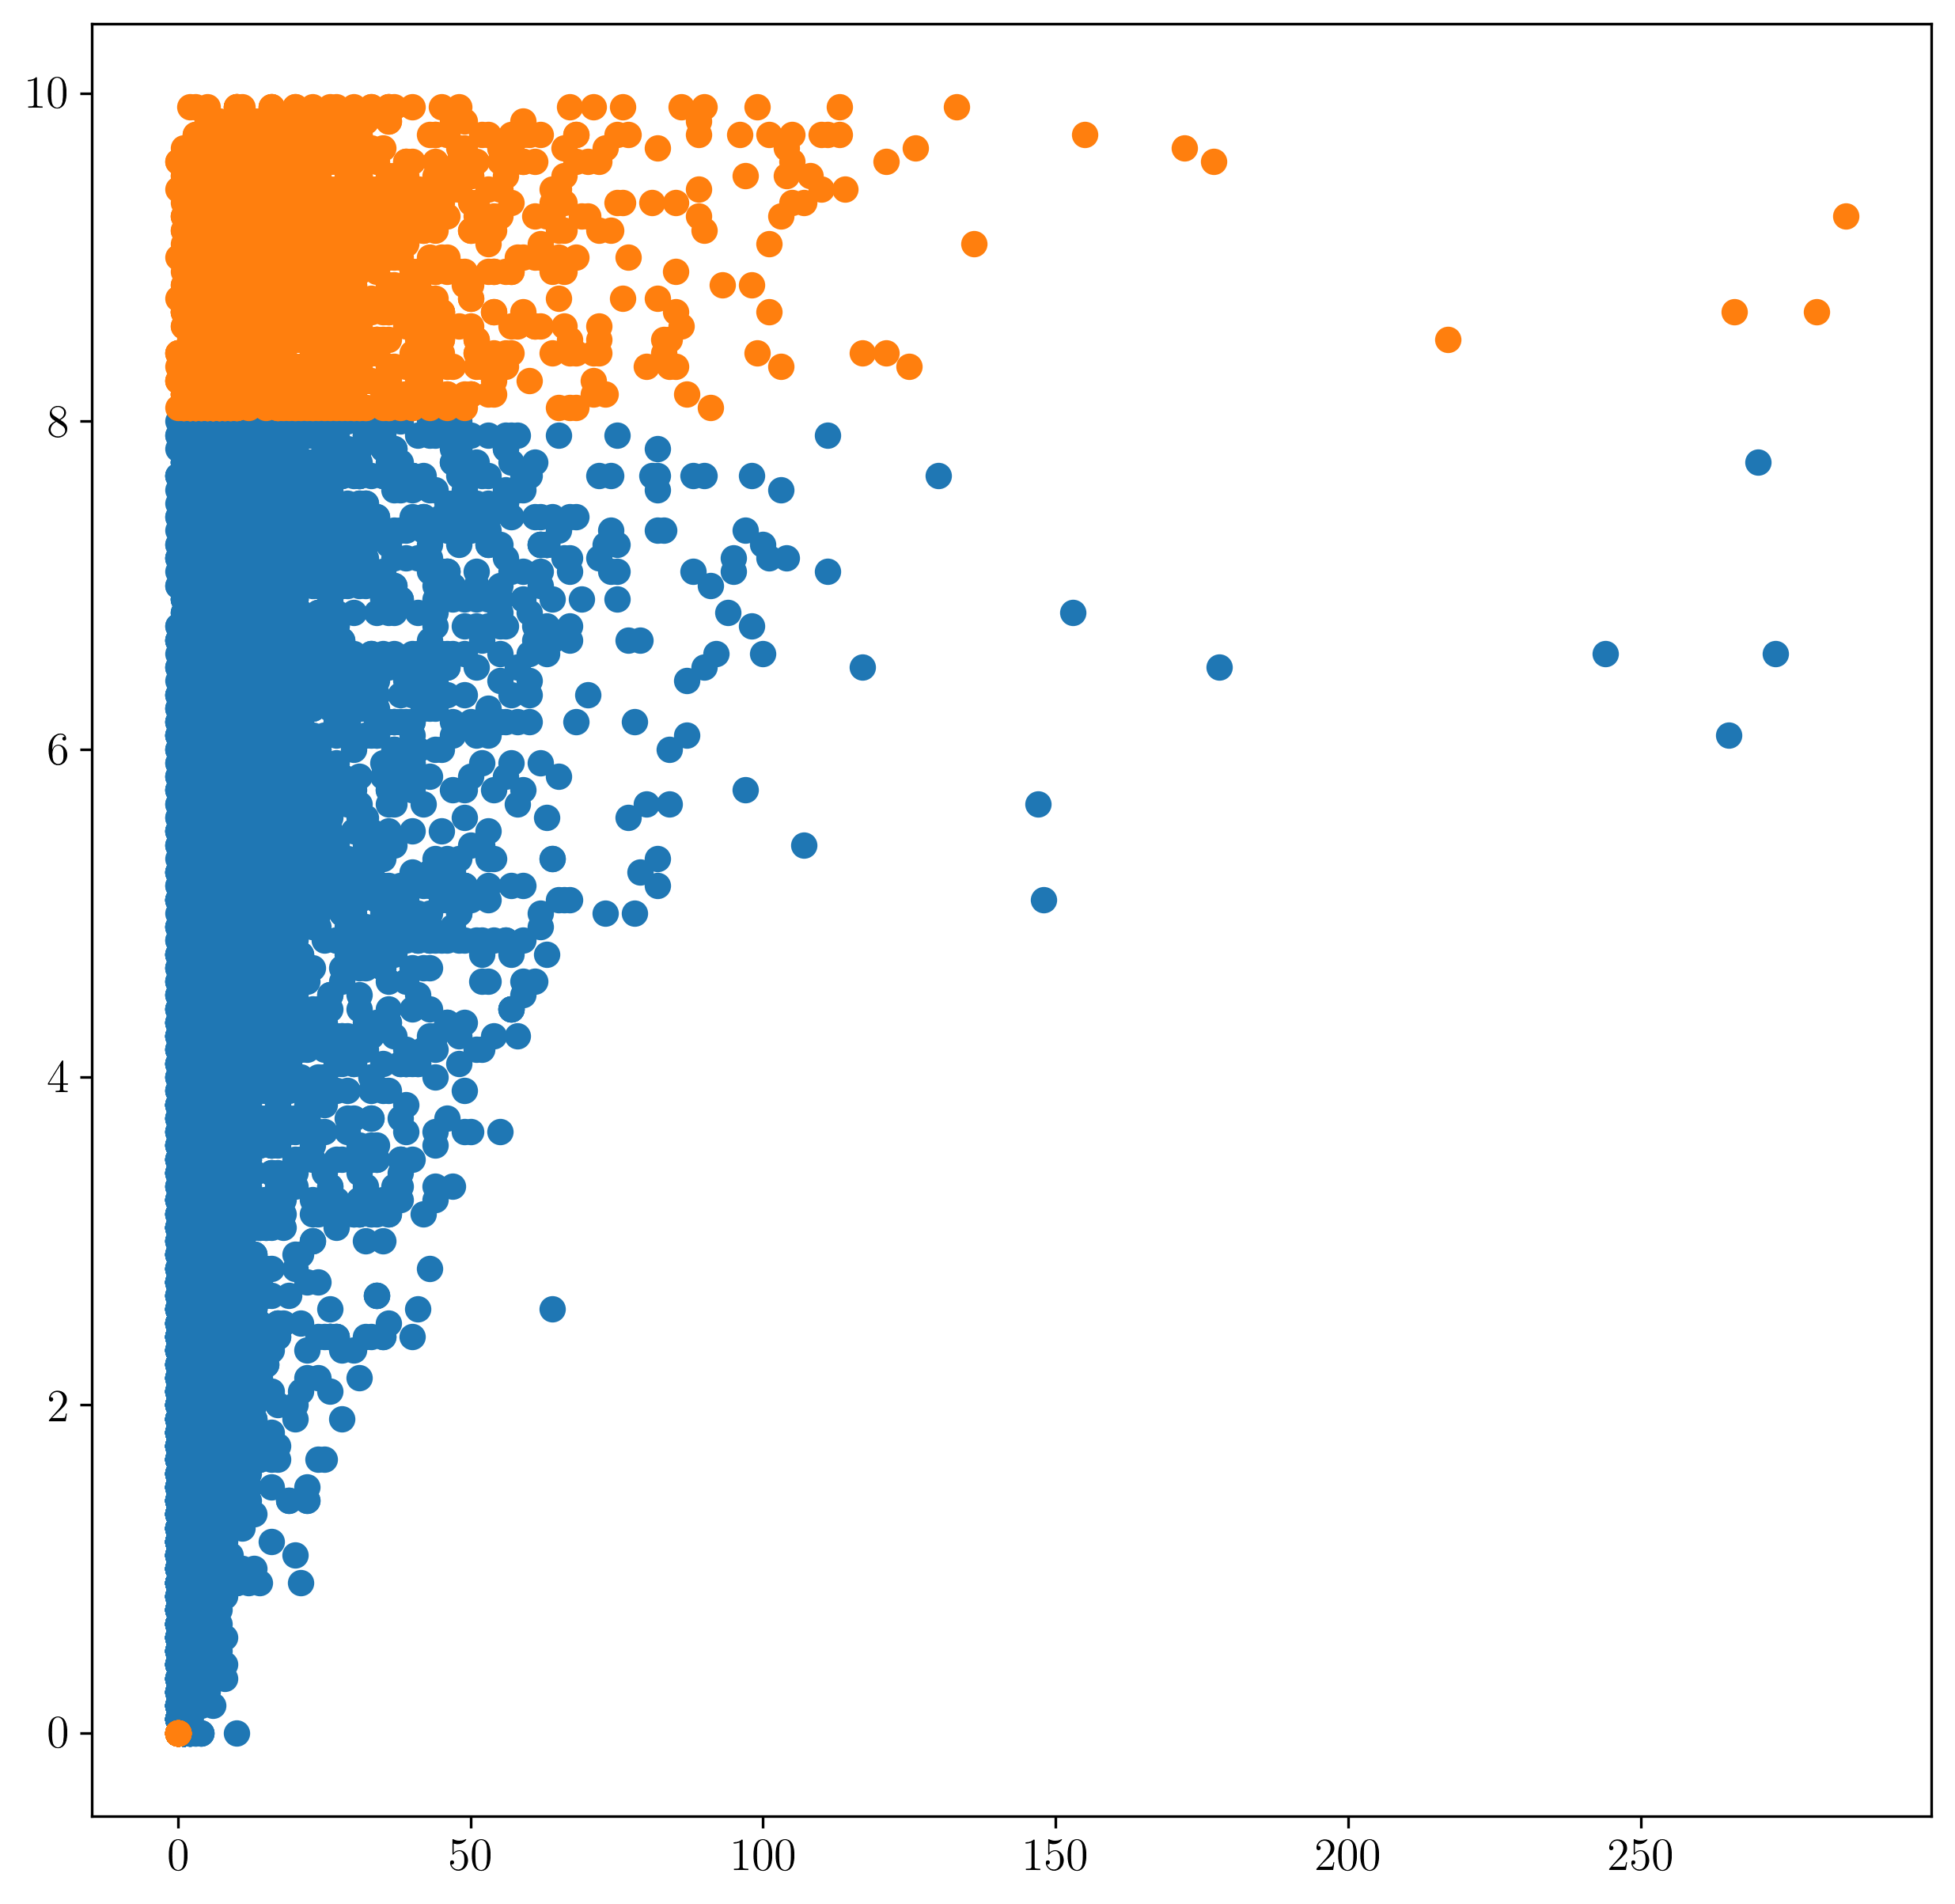

In [34]:
fig, ax = plt.subplots()
ax.scatter(inactive_nth_author_pubs, inactive_longevity)
ax.scatter(active_nth_author_pubs, active_longevity)

In [14]:
# Now we want to ask:
# - How many people (from both cohorts) published 1 first-author paper in their first five years?
# - How many ... N first-author papers in their first ...

set(inactive_names).intersection(set(active_names))

set()

In [19]:
# For each name, calculate some metrics so we can plot the fraction of inactive / total as a function of
# those metrics.
bins = np.arange(1, 21)
bins_for_total = np.arange(1, 30)

inactive_single_author_pubs = np.zeros_like(bins)
inactive_first_author_pubs = np.zeros_like(bins)
inactive_nth_author_pubs = np.zeros_like(bins)
inactive_total_author_pubs = np.zeros_like(bins_for_total)

active_single_author_pubs = np.zeros_like(bins)
active_first_author_pubs = np.zeros_like(bins)
active_nth_author_pubs = np.zeros_like(bins)
active_total_author_pubs = np.zeros_like(bins_for_total)


for name in inactive_names:
    profile = profiles["astro-ph"][name]
    n_first = sum([(1 if index == 0 else 0) for (arxiv_id, index) in profile])
    n_nth = sum([(1 if index != 0 else 0) for (arxiv_id, index) in profile])
    n_single = sum([(1 if (index == 0 and len(authors[arxiv_id]) == 1) else 0) for (arxiv_id, index) in profile])
    
    inactive_first_author_pubs[min(n_first, bins.size) - 1] += 1
    inactive_nth_author_pubs[min(n_nth, bins.size) - 1] += 1
    inactive_single_author_pubs[min(n_single, bins.size) - 1] += 1
        
    inactive_total_author_pubs[min(n_first + n_nth, bins_for_total.size) - 1] += 1
            
        
for name in active_names:
    profile = profiles["astro-ph"][name]
        
    # Only consider metrics within the first X years, since that is how long we specify
    # for the 'dead' cohort.
    sorted_profile = sorted(profile, key=sorter)
    first_pub_date = sorter([profile[0][0]])
    n_first, n_nth, n_single = (0, 0, 0)
    for arxiv_id, index in profile:
        pub_date = sorter([arxiv_id])
        if (pub_date - first_pub_date) > career_length: 
            break
        
        if index == 0:
            n_first += 1
            if len(authors[arxiv_id]) == 1:
                n_single += 1
        else:
            n_nth += 1
    
    active_first_author_pubs[min(n_first, bins.size) - 1] += 1
    active_nth_author_pubs[min(n_nth, bins.size) - 1] += 1
    active_single_author_pubs[min(n_single, bins.size) - 1] += 1

    active_total_author_pubs[min(n_first + n_nth, bins_for_total.size) - 1] += 1
    
    

<ipython-input-20-0caacc65e184>:19: RuntimeWarning: invalid value encountered in true_divide
  y_single = active_single_author_pubs / (inactive_single_author_pubs + active_single_author_pubs)


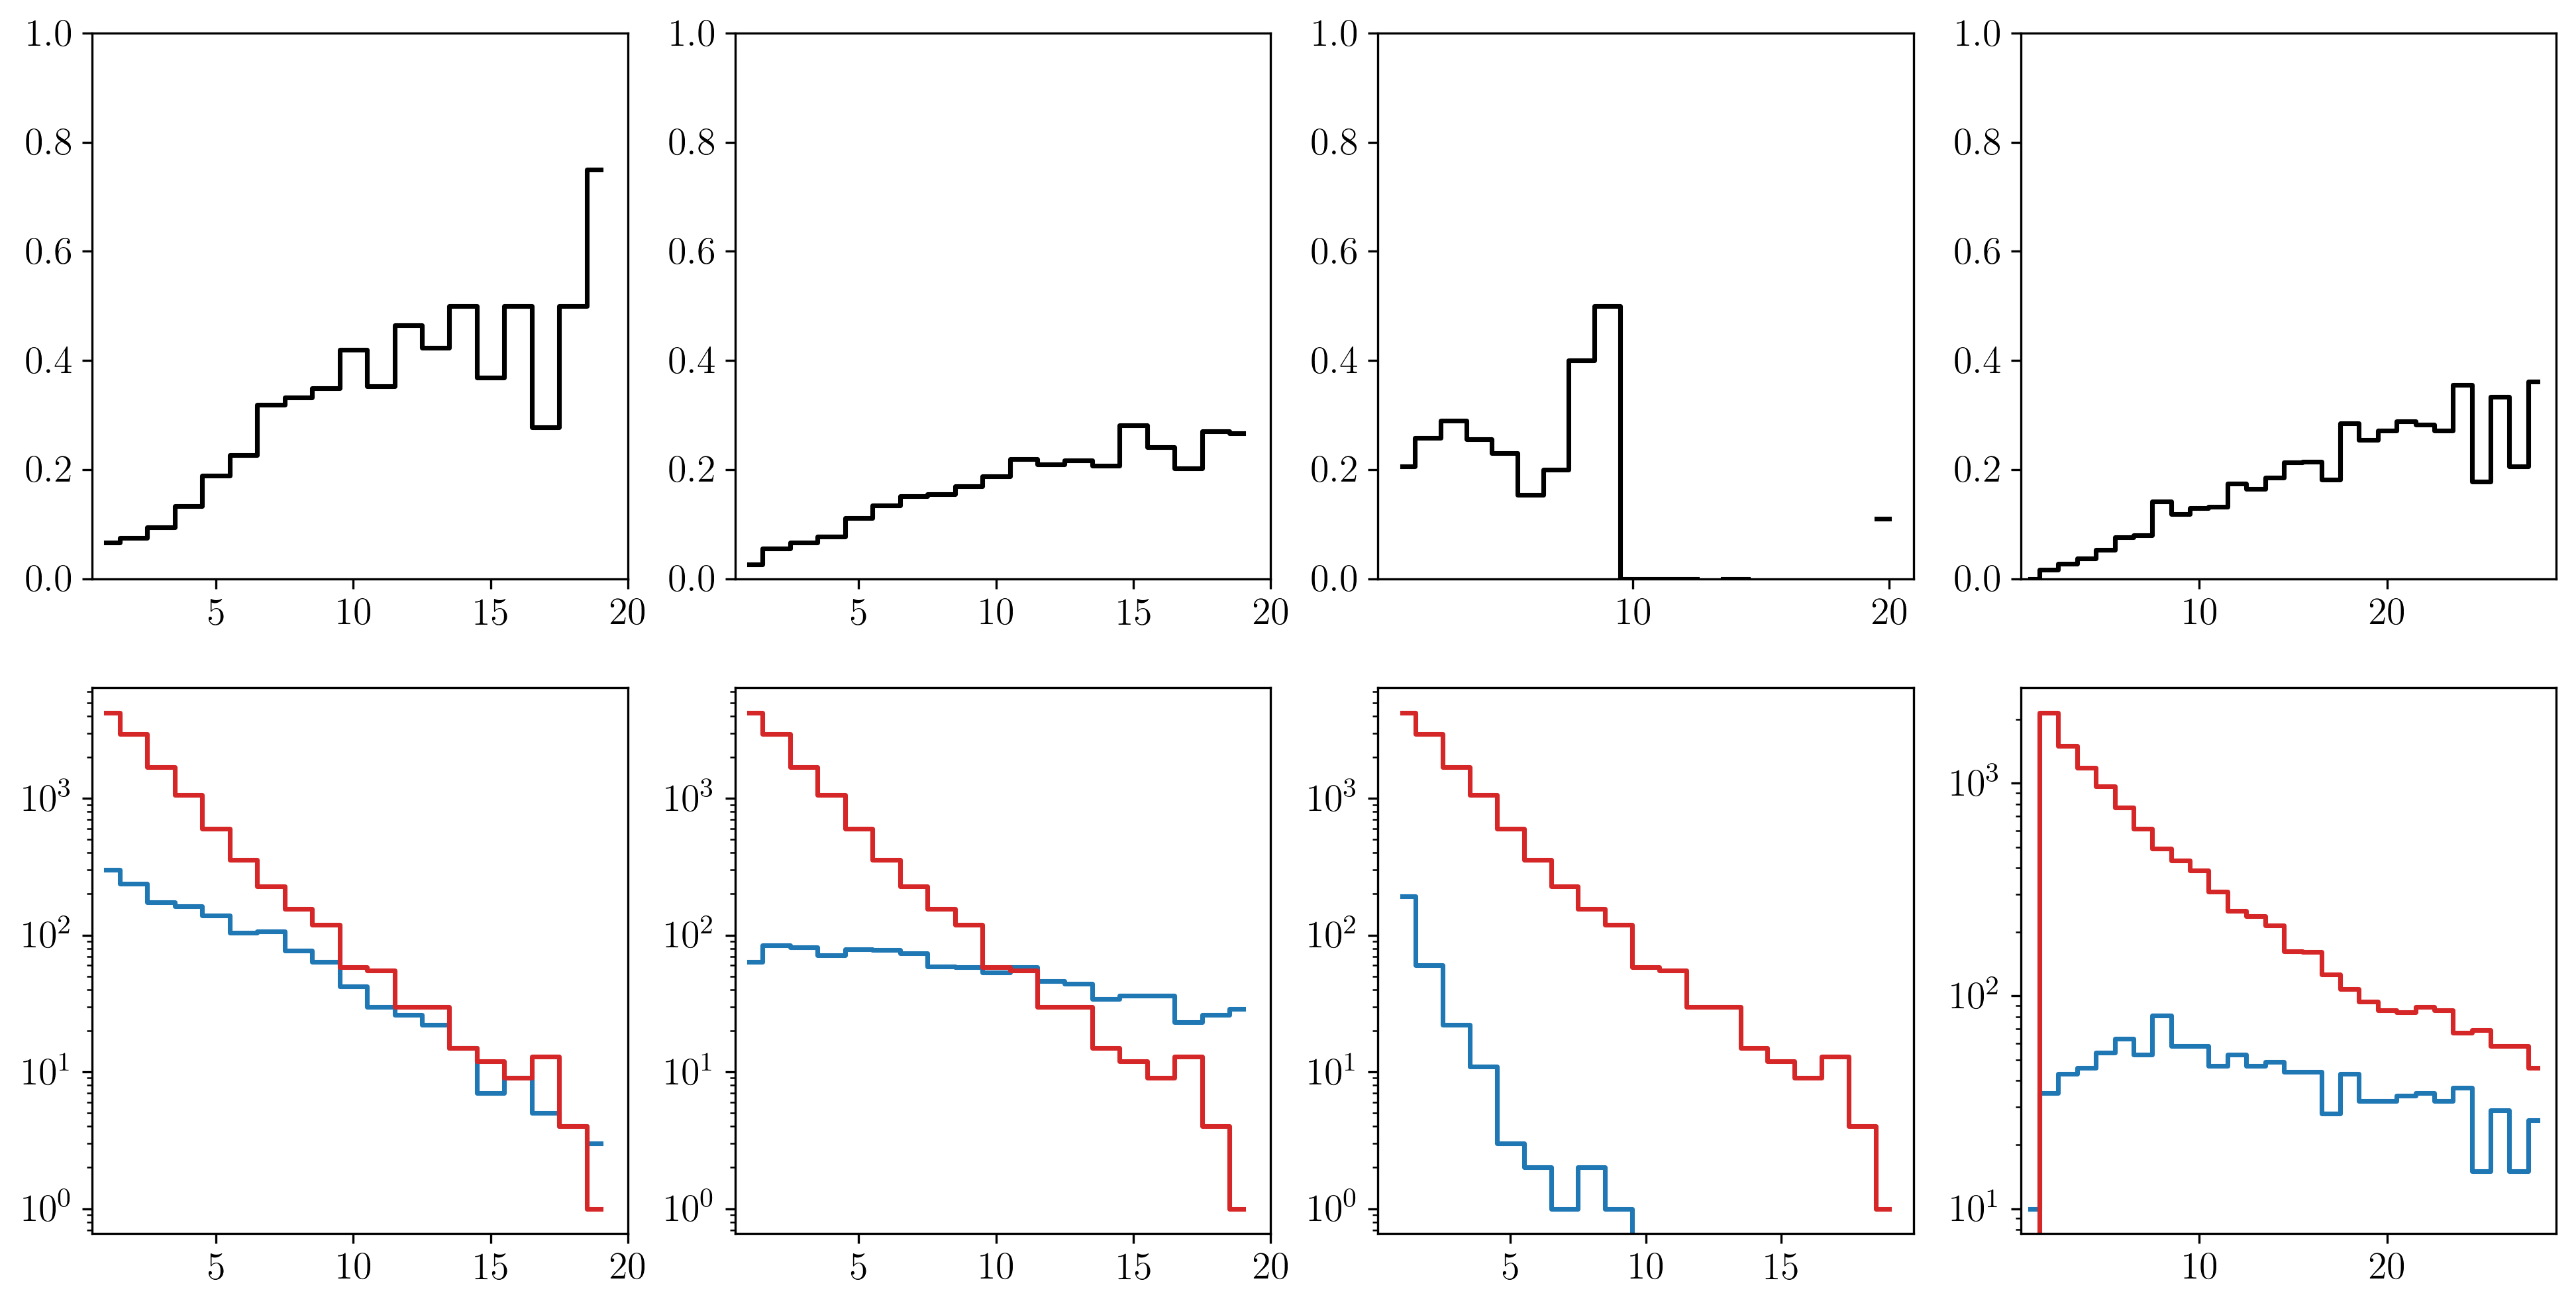

In [20]:
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

ax_first, ax_nth, ax_single, ax_total = axes[0]
n_ax_first, n_ax_nth, n_ax_single, n_ax_total = axes[1]

y_first = active_first_author_pubs / (inactive_first_author_pubs + active_first_author_pubs)
ax_first.plot(bins[:-1], y_first[:-1], c="k", ls="-", drawstyle="steps-mid")
n_ax_first.plot(bins[:-1], active_first_author_pubs[:-1], c="tab:blue", drawstyle="steps-mid")
n_ax_first.plot(bins[:-1], inactive_first_author_pubs[:-1], c="tab:red", drawstyle="steps-mid")
n_ax_first.set_yscale("log")


y_nth = active_nth_author_pubs / (inactive_nth_author_pubs + active_nth_author_pubs)
ax_nth.plot(bins[:-1], y_nth[:-1], c="k", ls="-", drawstyle="steps-mid")
n_ax_nth.plot(bins[:-1], active_nth_author_pubs[:-1], c="tab:blue", drawstyle="steps-mid")
n_ax_nth.plot(bins[:-1], inactive_first_author_pubs[:-1], c="tab:red", drawstyle="steps-mid")
n_ax_nth.set_yscale("log")

y_single = active_single_author_pubs / (inactive_single_author_pubs + active_single_author_pubs)
ax_single.plot(bins, y_single, c="k", ls="-", drawstyle="steps-mid")
n_ax_single.plot(bins[:-1], active_single_author_pubs[:-1], c="tab:blue", drawstyle="steps-mid")
n_ax_single.plot(bins[:-1], inactive_first_author_pubs[:-1], c="tab:red", drawstyle="steps-mid")
n_ax_single.set_yscale("log")


y_total = active_total_author_pubs \
        / (active_total_author_pubs + inactive_total_author_pubs)
y_total[0] = 0 # by definition
ax_total.plot(bins_for_total[:-1], y_total[:-1], c="k", ls="-", drawstyle="steps-mid")

#for ax in axes:
#    ax.set_ylim(0, 1)
n_ax_total.plot(bins_for_total[:-1], active_total_author_pubs[:-1], c="tab:blue", drawstyle="steps-mid")
n_ax_total.plot(bins_for_total[:-1], inactive_total_author_pubs[:-1], c="tab:red", drawstyle="steps-mid")
n_ax_total.set_yscale("log")

for ax in axes[0]:
    ax.set_ylim(0, 1)
    
for ax in (ax_first, ax_nth, n_ax_first, n_ax_nth):
    ax.set_xlim(0.5, bins[-1])
    
for ax in (ax_total, n_ax_total):
    ax.set_xlim(0.5, bins_for_total[-1])


In [21]:
# Let's do a 2d histogram for number of first author papers and number of nth author papers.
B_first = np.arange(0, 10)
B_nth = np.arange(0, 20)

shape = (B_first.size, B_nth.size)

active_grid = np.zeros(shape)
inactive_grid = np.zeros(shape)

for name in inactive_names:
    profile = profiles["astro-ph"][name]
    n_first = sum([(1 if index == 0 else 0) for (arxiv_id, index) in profile])
    n_nth = sum([(1 if index != 0 else 0) for (arxiv_id, index) in profile])

    try:
        inactive_grid[n_first, n_nth] += 1
    except IndexError:
        # Out of grid.
        None
        
for name in active_names:
    profile = profiles["astro-ph"][name]
        
    # Only consider metrics within the first 5 years, since that is how long we specify
    # for the 'dead' cohort.
    sorted_profile = sorted(profile, key=sorter)
    first_pub_date = sorter([profile[0][0]])
    n_first, n_nth, n_single = (0, 0, 0)
    for arxiv_id, index in profile:
        pub_date = sorter([arxiv_id])
        if (pub_date - first_pub_date) > 5: 
            break
        
        if index == 0:
            n_first += 1
        else:
            n_nth += 1

    #if n_nth == 1 and n_first == 0:
    #    raise a
    try:
        active_grid[n_first, n_nth] += 1
    except IndexError:
        None

<ipython-input-22-47eff96eb3ef>:1: RuntimeWarning: invalid value encountered in true_divide
  Z = active_grid / (inactive_grid + active_grid)


Text(0.5, 1.0, 'inactive')

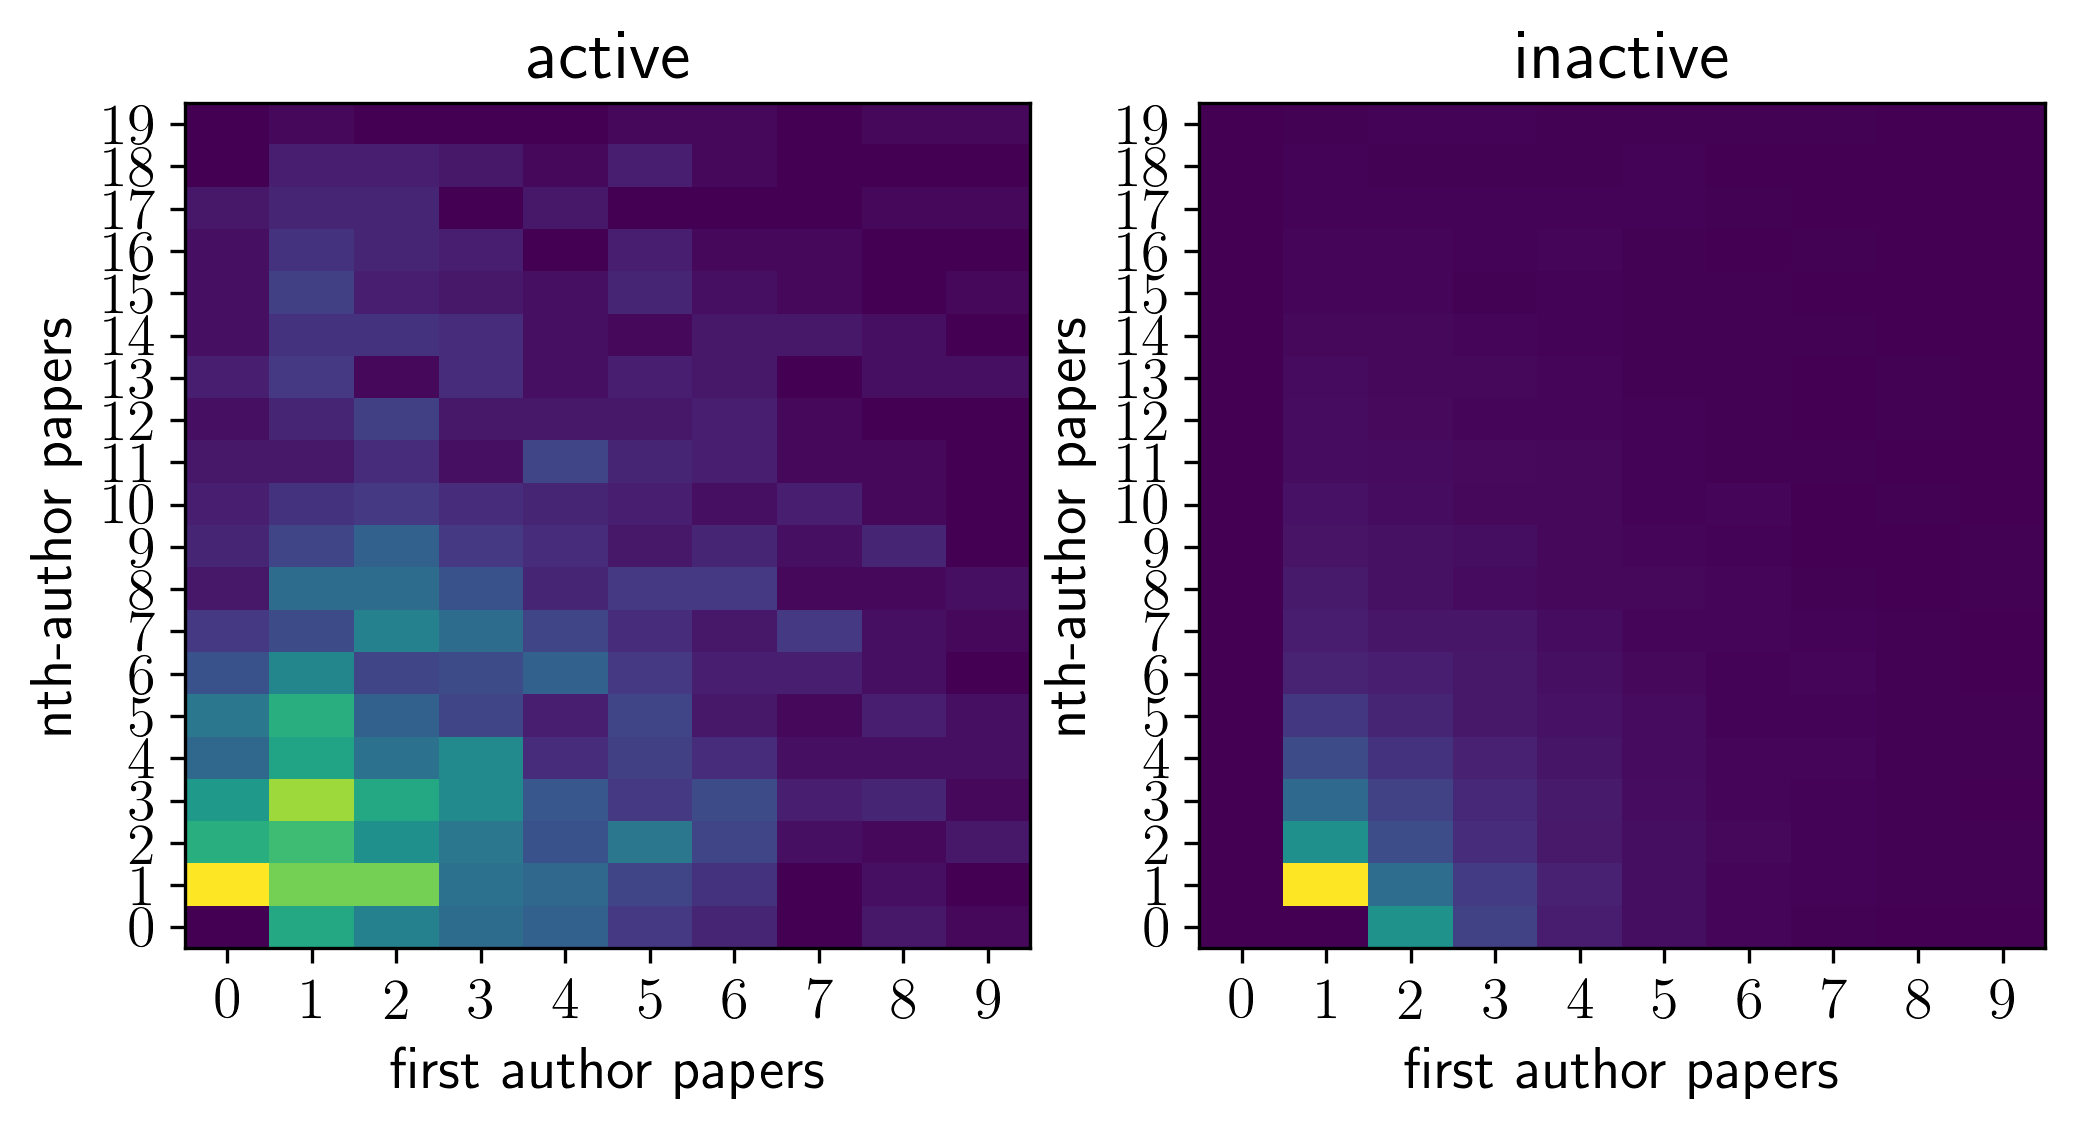

In [22]:
Z = active_grid / (inactive_grid + active_grid)

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
im = axes[0].imshow(
    active_grid.T,
    aspect=0.5
)

im = axes[1].imshow(
    inactive_grid.T,
    aspect=0.5,
)
for ax in axes:
    ax.set_xticks(B_first)
    ax.set_yticks(B_nth)
    ax.set_ylim(ax.get_ylim()[::-1])
    ax.set_xlabel("first author papers")
    ax.set_ylabel("nth-author papers")
axes[0].set_title("active")
axes[1].set_title("inactive")
#ax.set_ylim(ax.get_ylim()[::-1])
#ax.set_xticks(B_first)
#ax.set_yticks(B_nth)
#cbar = plt.colorbar(im)

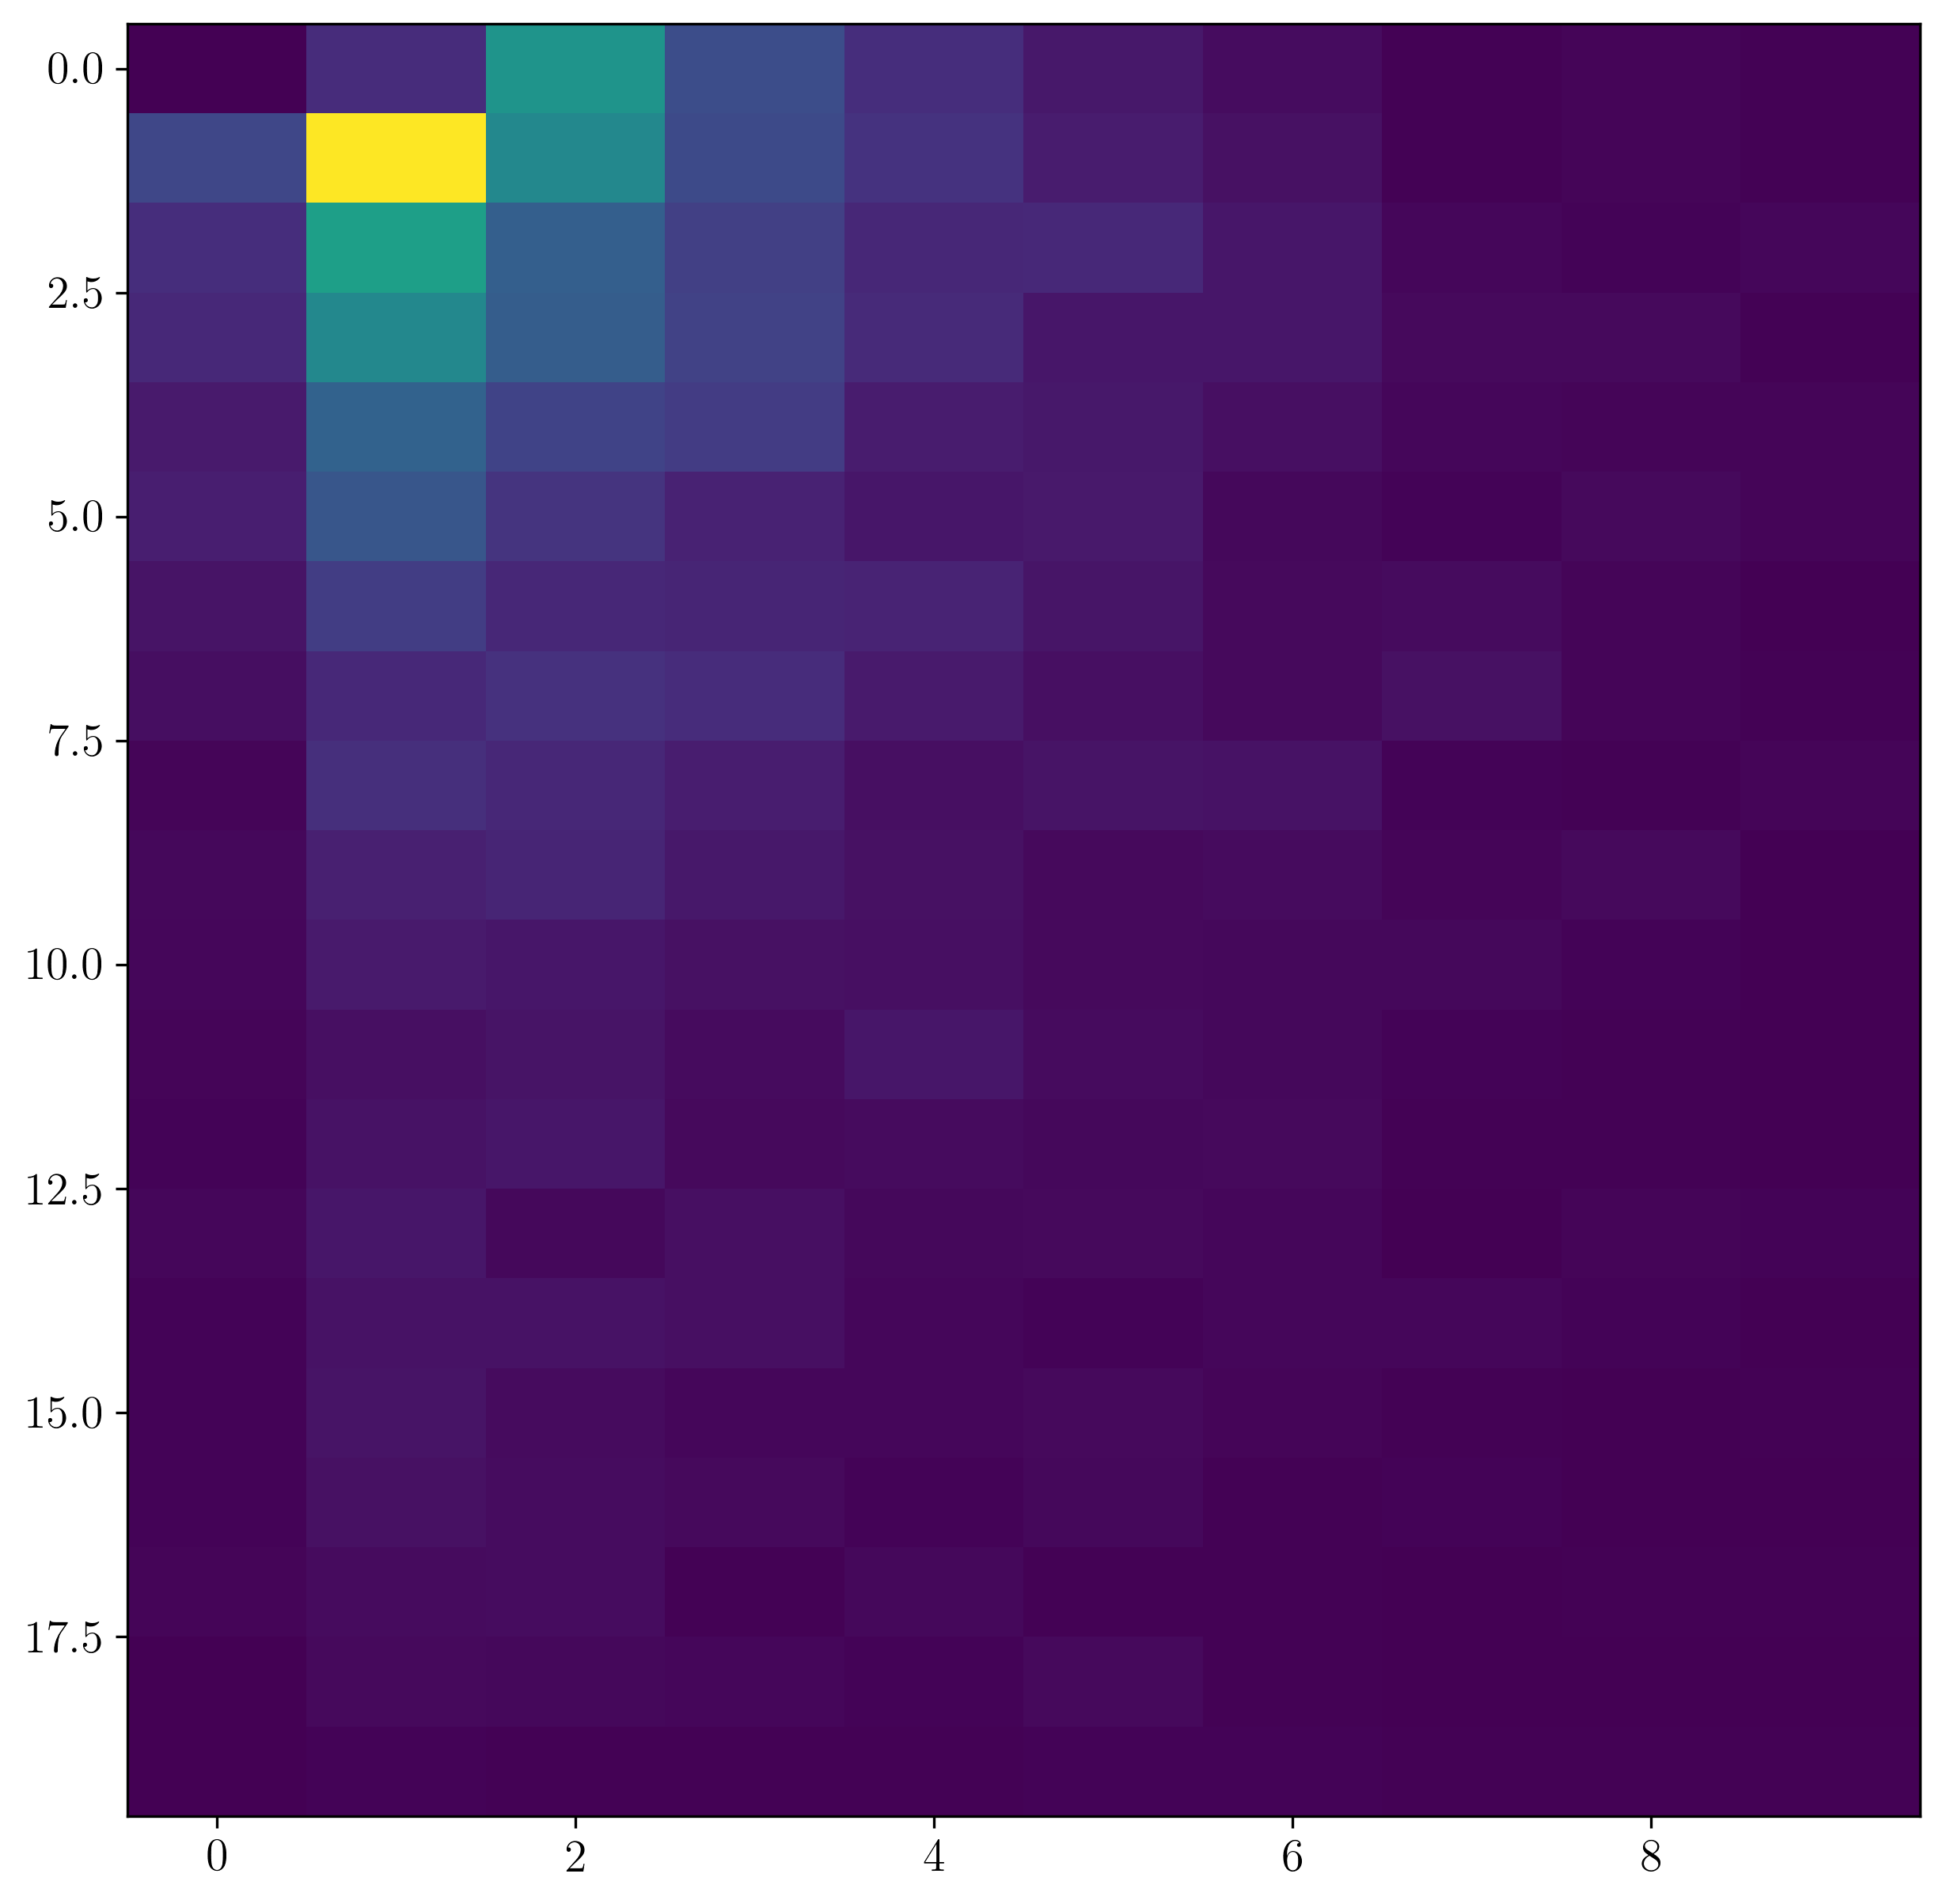

In [26]:
Z = inactive_grid/inactive_grid.sum() + active_grid/active_grid.sum()

fig, ax = plt.subplots(1, 1)
ax.imshow(
    Z.T,
    aspect=0.5
)
#ax.set_ylim(ax.get_ylim()[::-1])
#ax.set_xticks(B_first)
#ax.set_yticks(B_nth)
#cbar = plt.colorbar(im)

<ipython-input-216-0ba8d9e9b685>:1: RuntimeWarning: invalid value encountered in true_divide
  Z = active_grid / (inactive_grid + active_grid)


(0.0, 20.0)

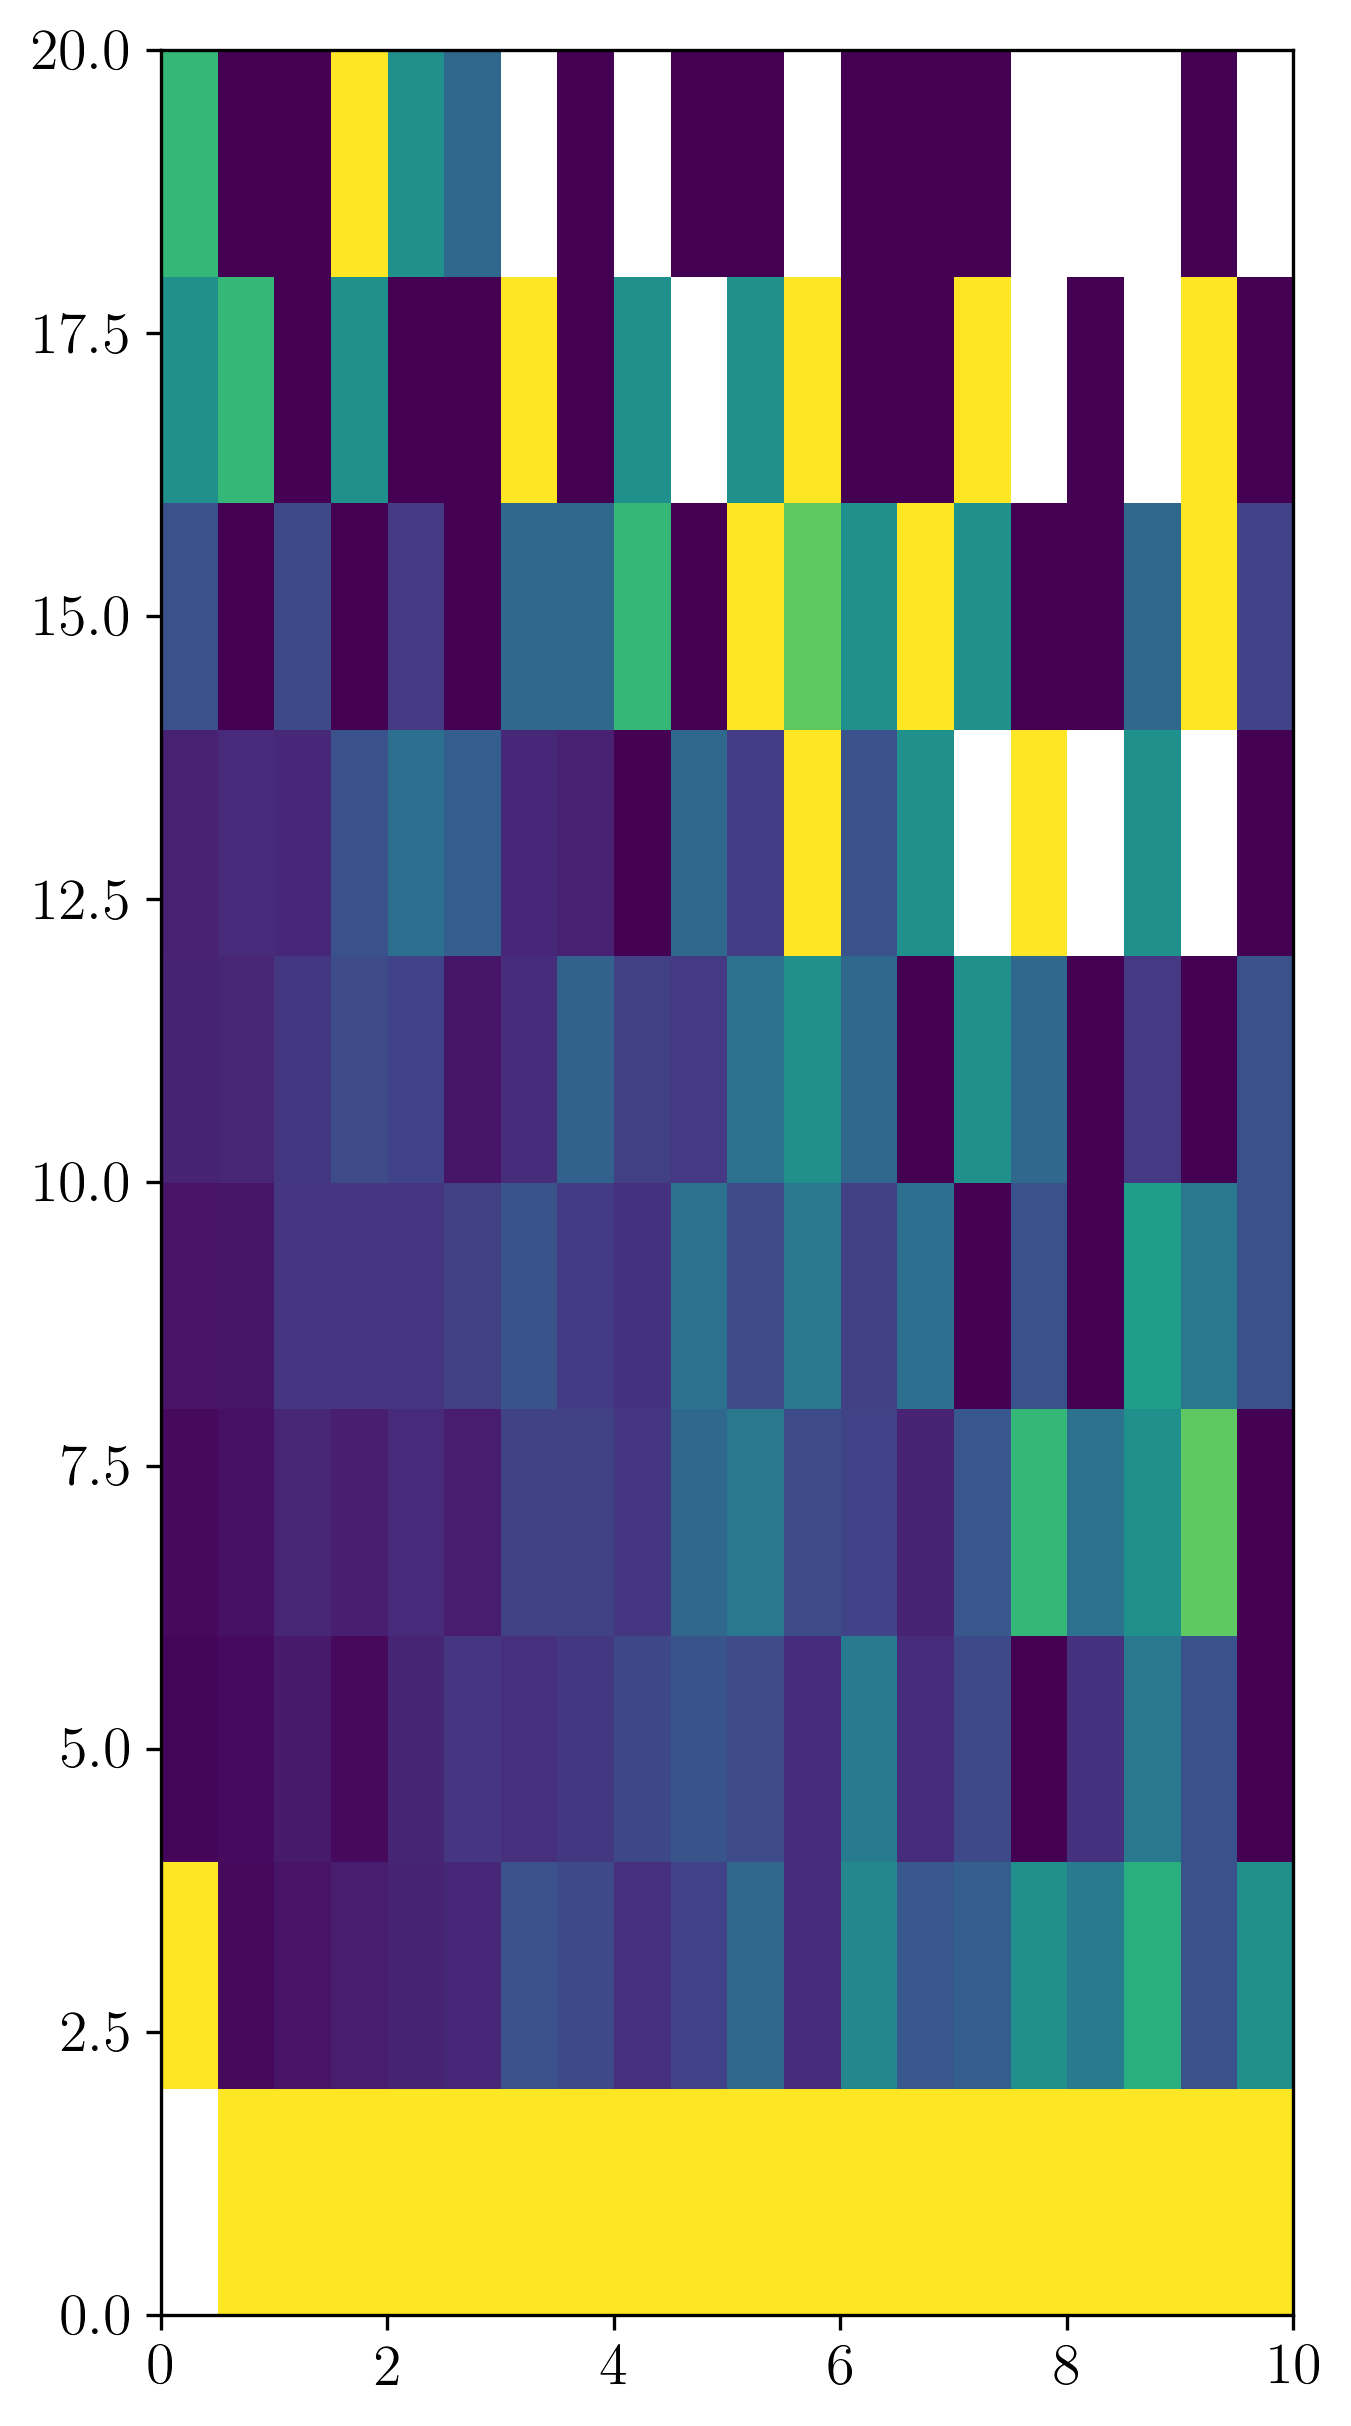

In [216]:
Z = active_grid / (inactive_grid + active_grid)

fig, ax = plt.subplots()
im = ax.imshow(
    Z,
    origin="upper",
    extent=(B_first[0], B_first[-1] + 1, B_nth[-1] + 1, B_nth[0]),
    aspect="equal"
)

ax.set_ylim(ax.get_ylim()[::-1])
#ax.set_xticks(B_first)
#ax.set_yticks(B_nth)
#cbar = plt.colorbar(im)

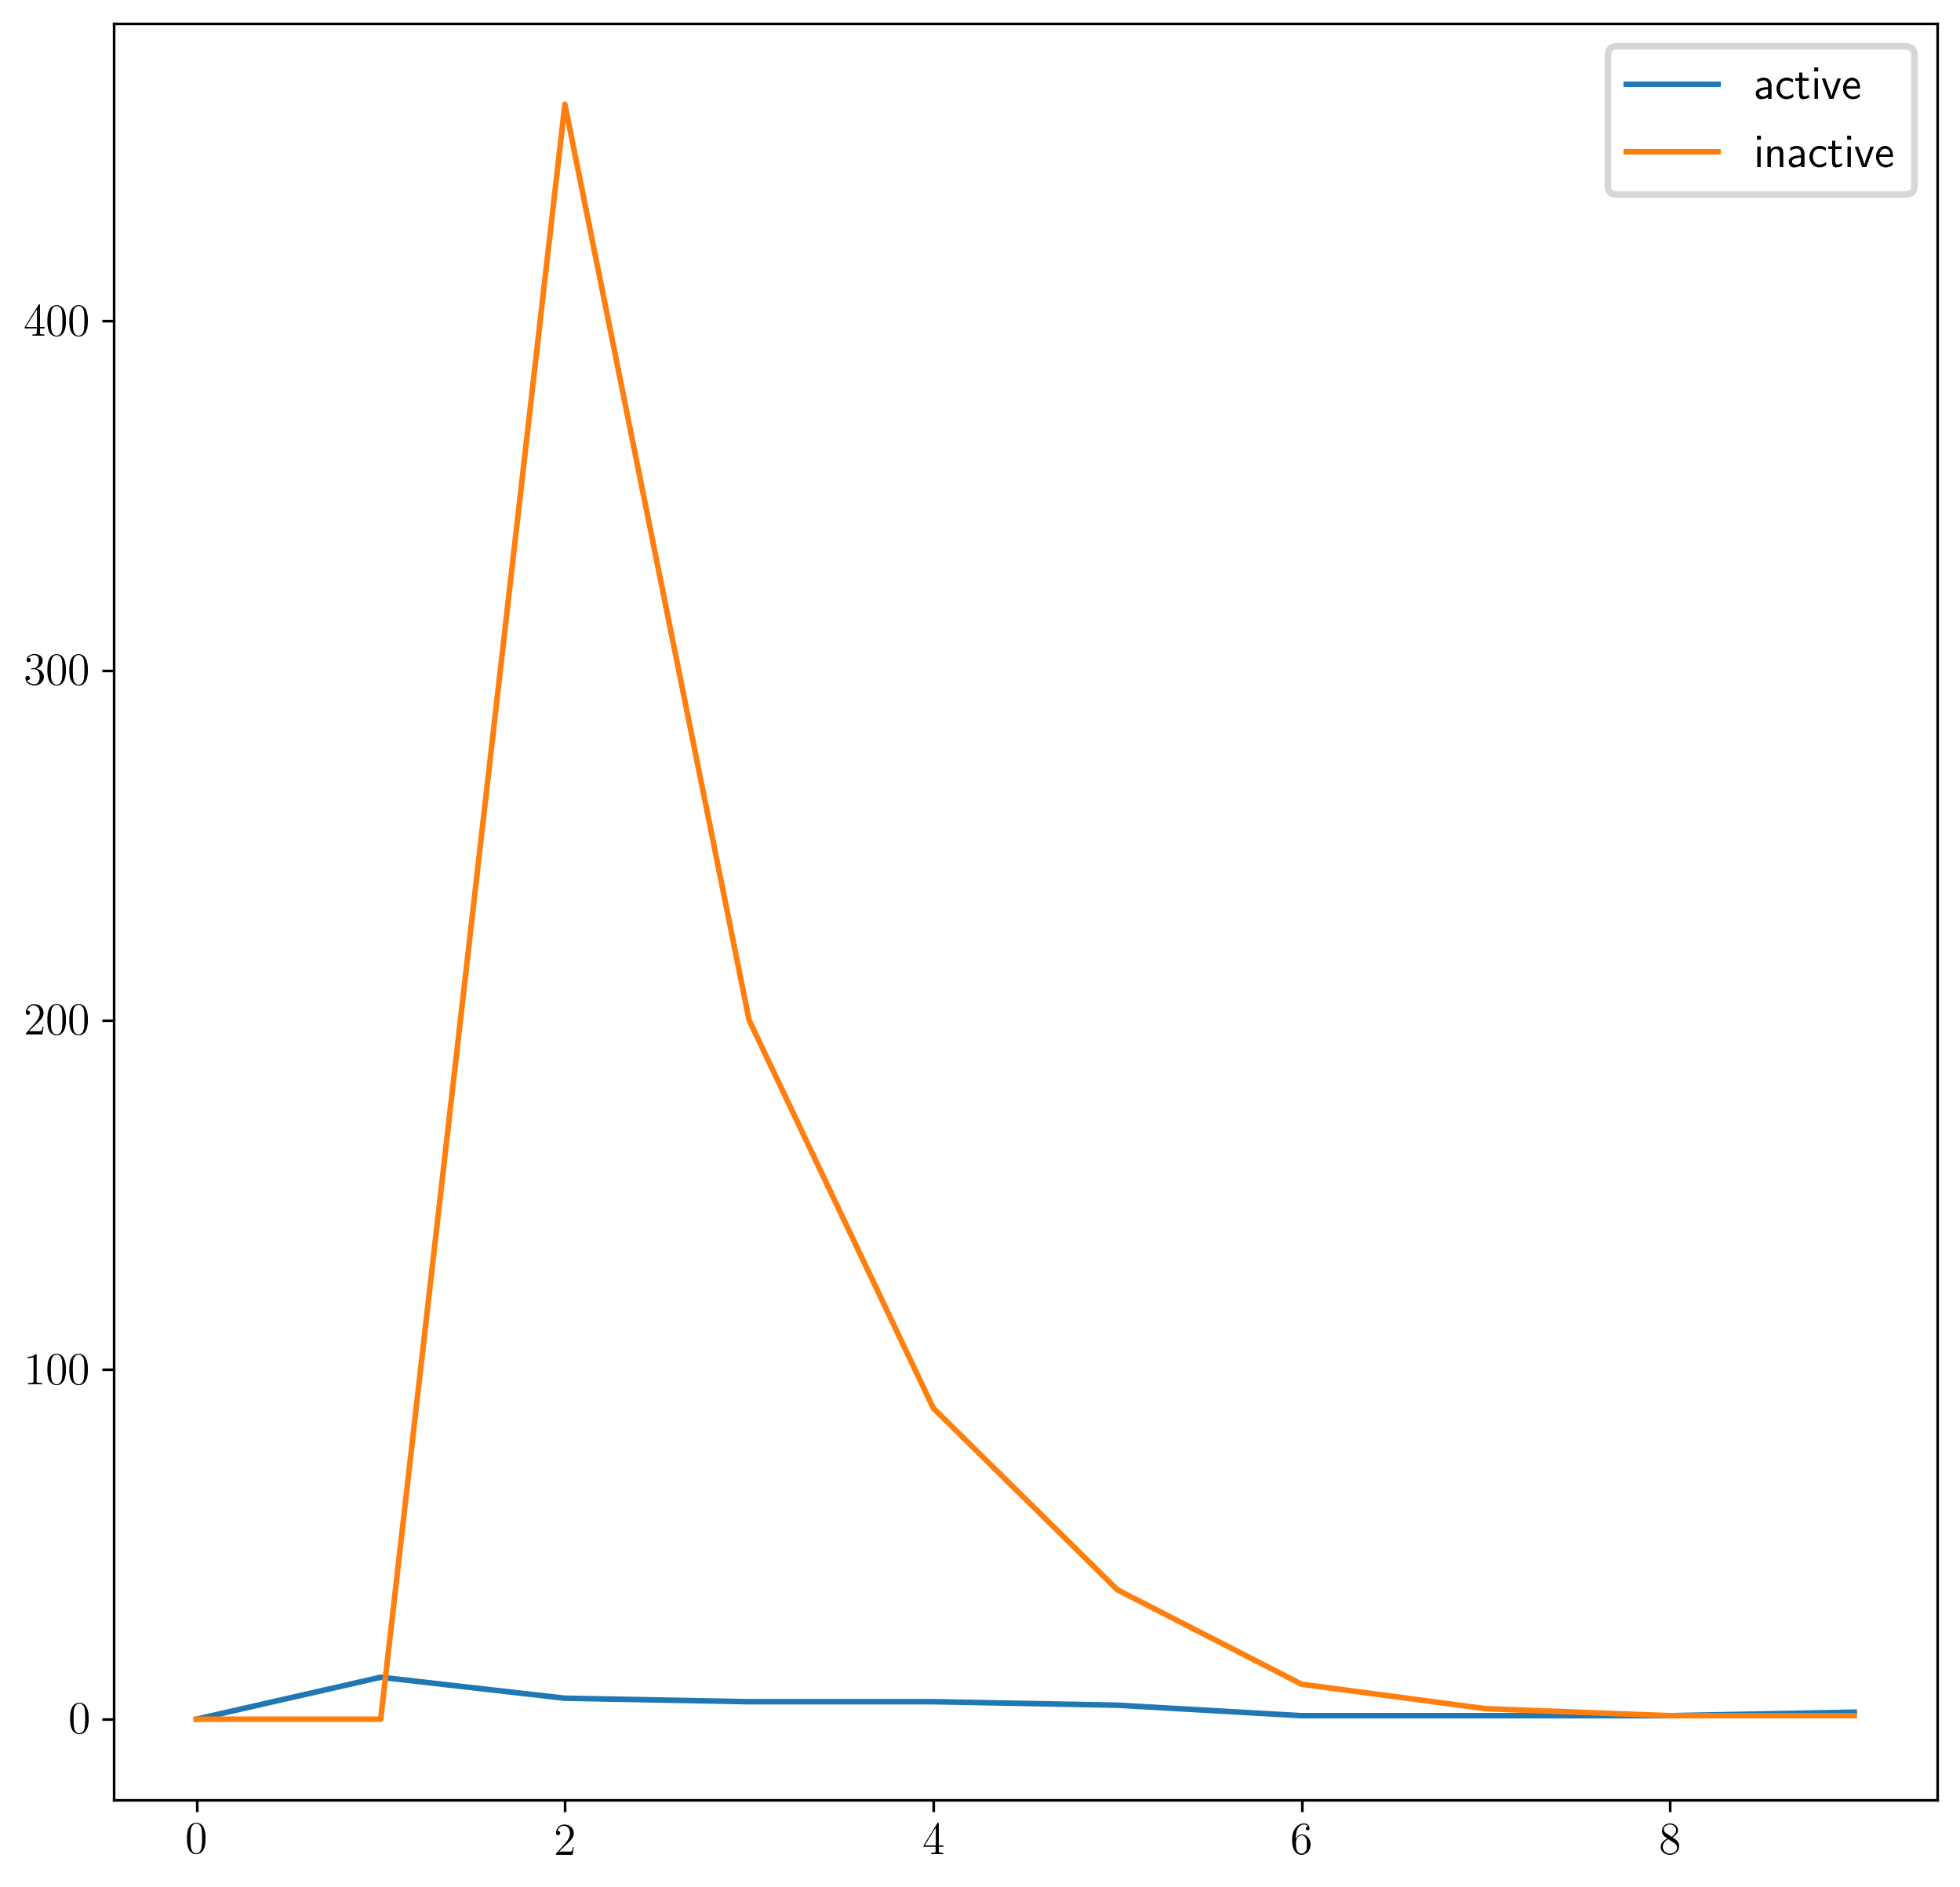

In [218]:
fig, ax = plt.subplots()
ax.plot(B_first, active_grid.T[0], label="active")
ax.plot(B_first, inactive_grid.T[0], label="inactive")
ax.legend()

In [39]:
# Let us calculate summary statistics of those that did not survive.
n_nth = []
n_first = []
n_single = []
for name in tqdm(inactive_names):
    profile = profiles["astro-ph"][name]
    
    n_first_ = sum((1 if idx == 0 else 0) for aid, idx in profile)
    n_nth_ = len(profile) - n_first_
        
    n_single_ = 0
    for aid, idx in profile:
        if idx == 0 and len(authors[aid]) == 1:
            n_single_ += 1

    n_nth.append(n_nth_)
    n_first.append(n_first_)    
    n_single.append(n_single_)

n_nth = np.array(n_nth)
n_first = np.array(n_first)
n_single = np.array(n_single)

100%|██████████| 6447/6447 [00:00<00:00, 49325.31it/s]


(array([478., 144.,  34.,  22.,  10.,   2.,   3.,   3.,   0.,   1.,   0.,
          0.,   1.]),
 array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5]),
 <a list of 13 Patch objects>)

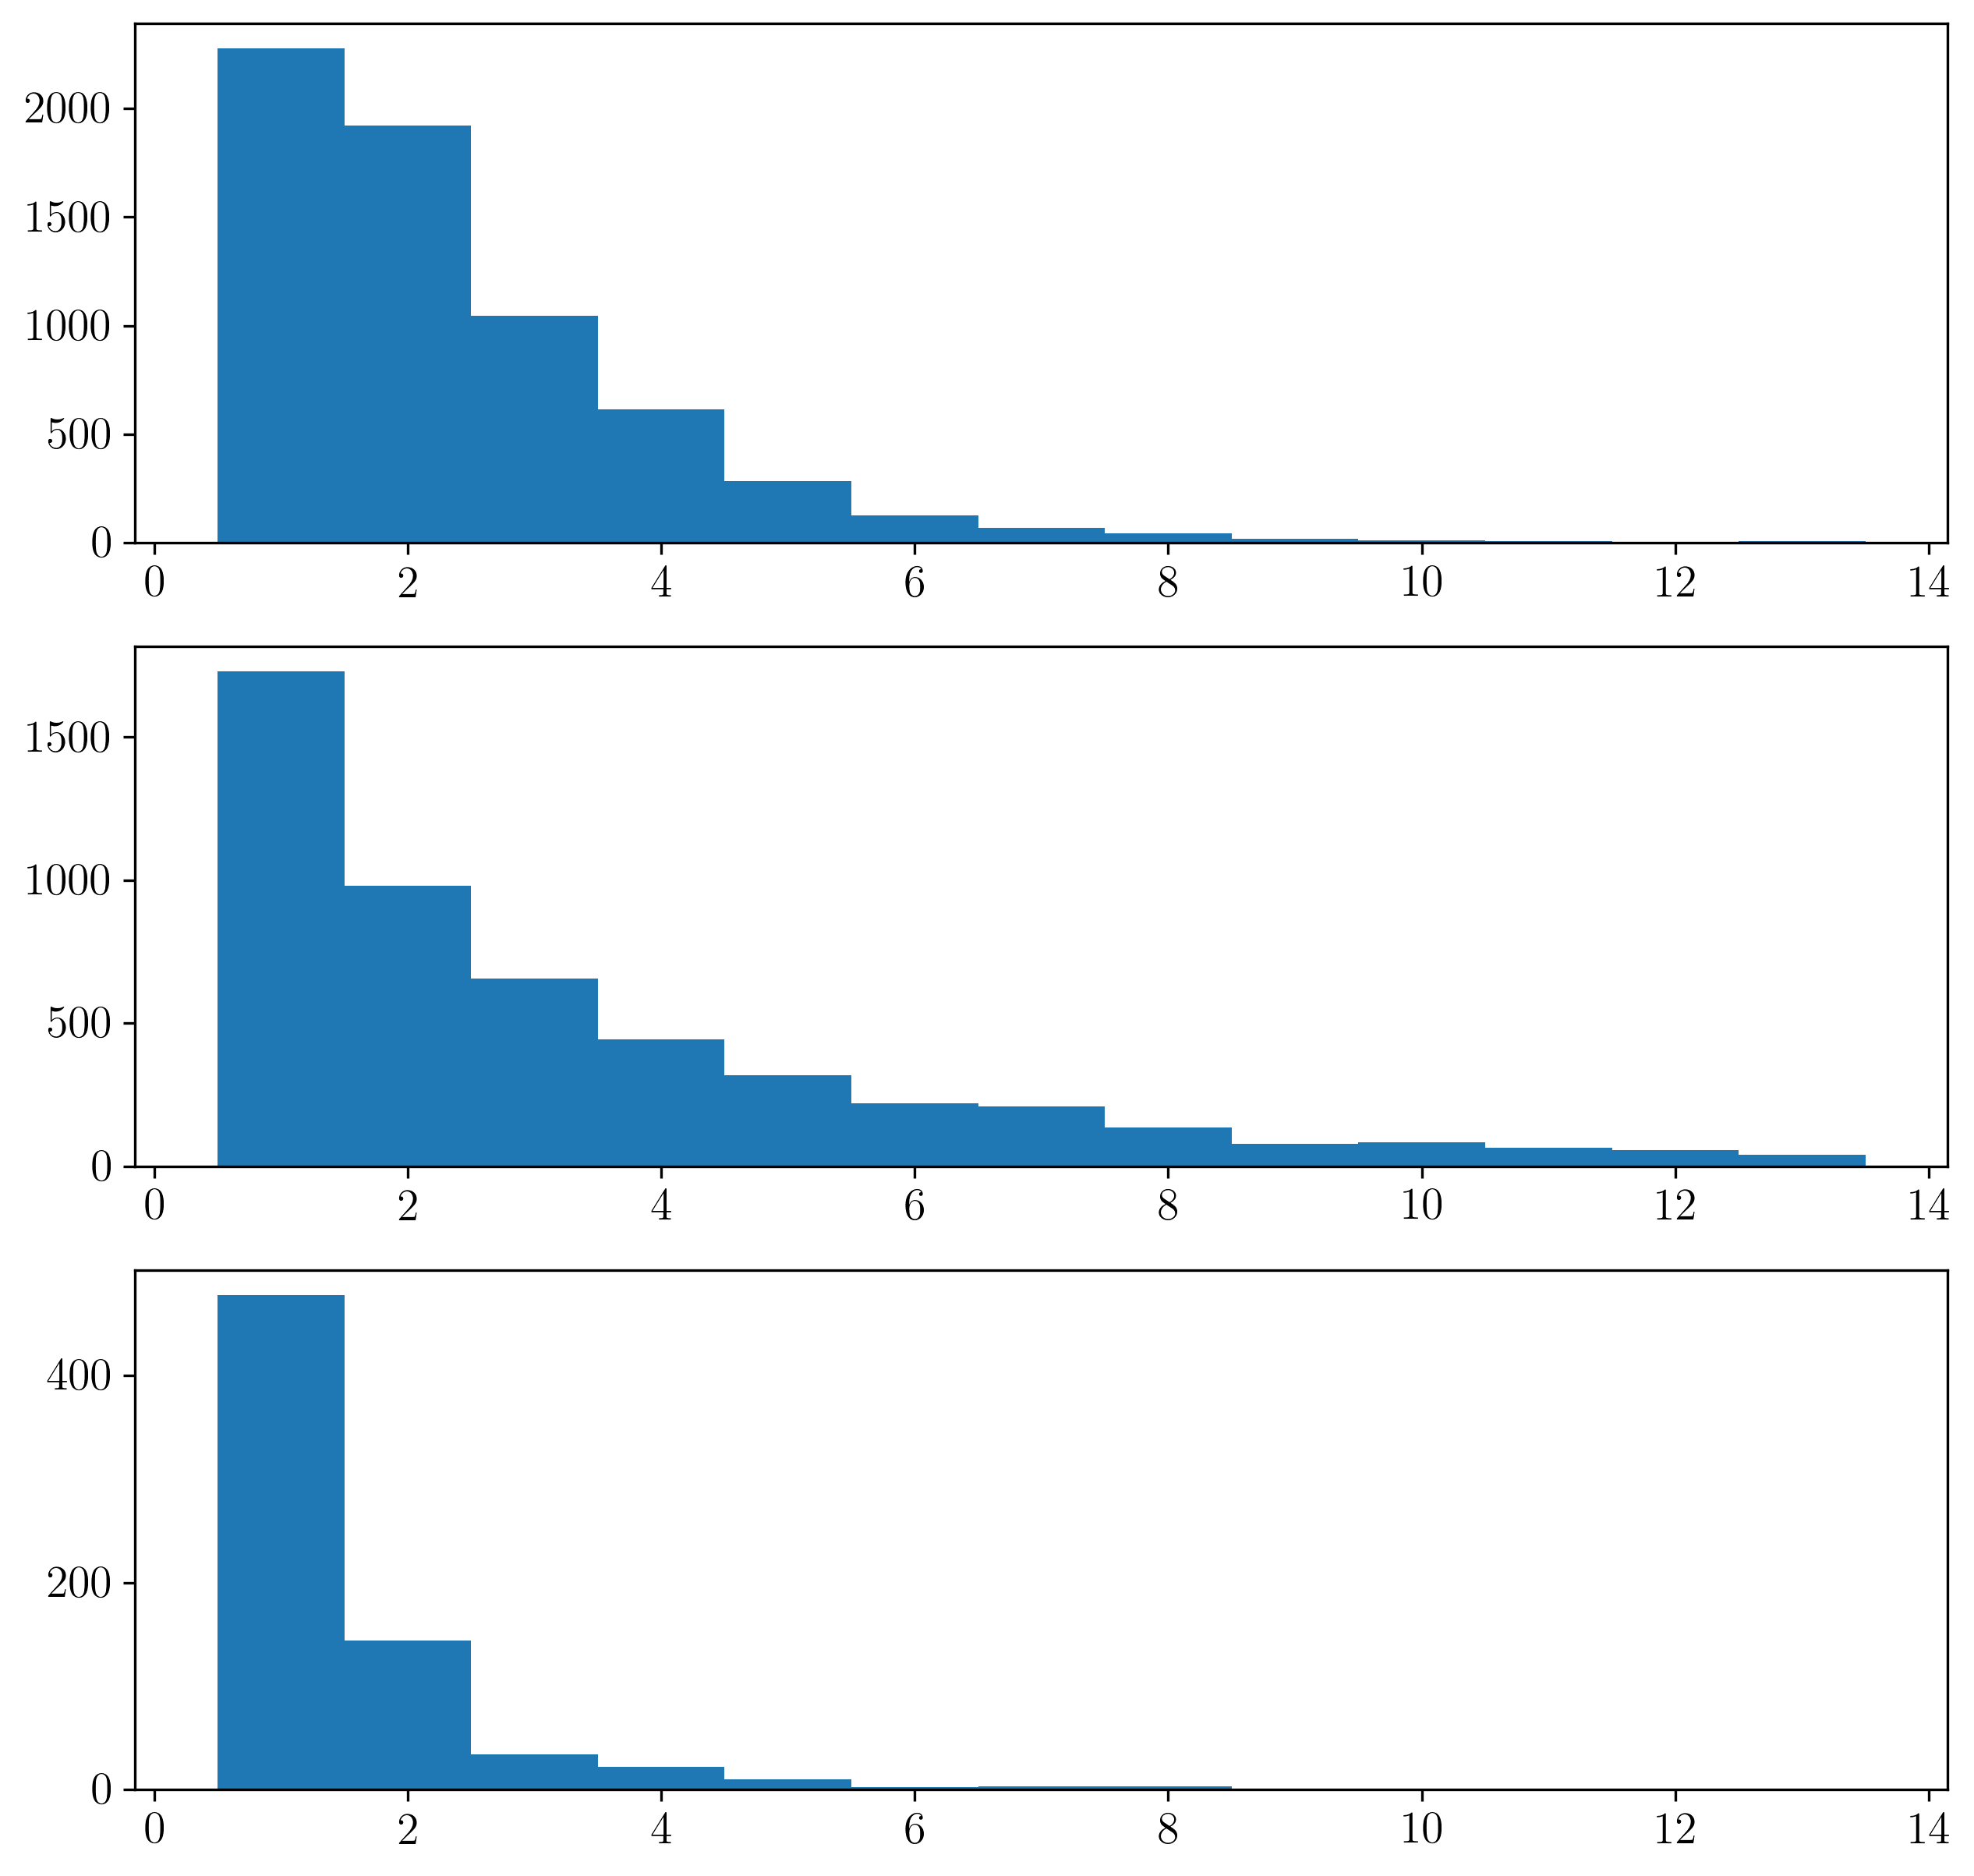

In [42]:
bins = np.arange(1, 15, 1)
fig, axes = plt.subplots(3, 1)
axes[0].hist(n_first, bins=bins - 0.5)
axes[1].hist(n_nth, bins=bins - 0.5)
axes[2].hist(n_single, bins=bins - 0.5)

In [ ]:
# Calculate 'longevity' for the active cohort so that we can answer questions like:
# If I publish 3 first author papers including 1 single author paper, what is my expected longevity?
active_names = set(profiles["astro-ph"]).difference(inactive_names)



In [13]:
# Define cohorts.
start_year, end_year, track_years = (2009, 2020, 4)

kwds = dict(track_years=4, ignore=common_names)

cohorts = {}
for ppc in ppcs:
    print(ppc)
    cohorts[ppc] = get_cohort(profiles[ppc], start_year, end_year, **kwds)

 33%|███▎      | 7481/22714 [00:00<00:00, 74808.47it/s]

hep-ph


 25%|██▍       | 4816/19375 [00:00<00:00, 47230.59it/s]

nucl-ex


  0%|          | 0/140571 [00:00<?, ?it/s]

hep-lat
nucl-th
physics


  5%|▍         | 5157/108372 [00:00<00:02, 51558.13it/s]

cond-mat


  0%|          | 0/27394 [00:00<?, ?it/s]

hep-th
hep-ex


 10%|▉         | 8567/87608 [00:00<00:02, 26858.23it/s]

astro-ph


  0%|          | 0/31376 [00:00<?, ?it/s]

q-bio
stat


 11%|█         | 3022/28103 [00:00<00:00, 30205.19it/s]

eess


  0%|          | 0/98569 [00:00<?, ?it/s]

math-ph
math


 29%|██▉       | 9566/32966 [00:00<00:00, 95632.27it/s]

quant-ph


 17%|█▋        | 2843/16680 [00:00<00:00, 28295.84it/s]

econ
q-fin
gr-qc


  3%|▎         | 5023/172711 [00:00<00:03, 50186.25it/s]

cs


100%|██████████| 9917/9917 [00:00<00:00, 179613.58it/s]

nlin


<ipython-input-42-719ed30f3791>:59: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  fig.tight_layout()


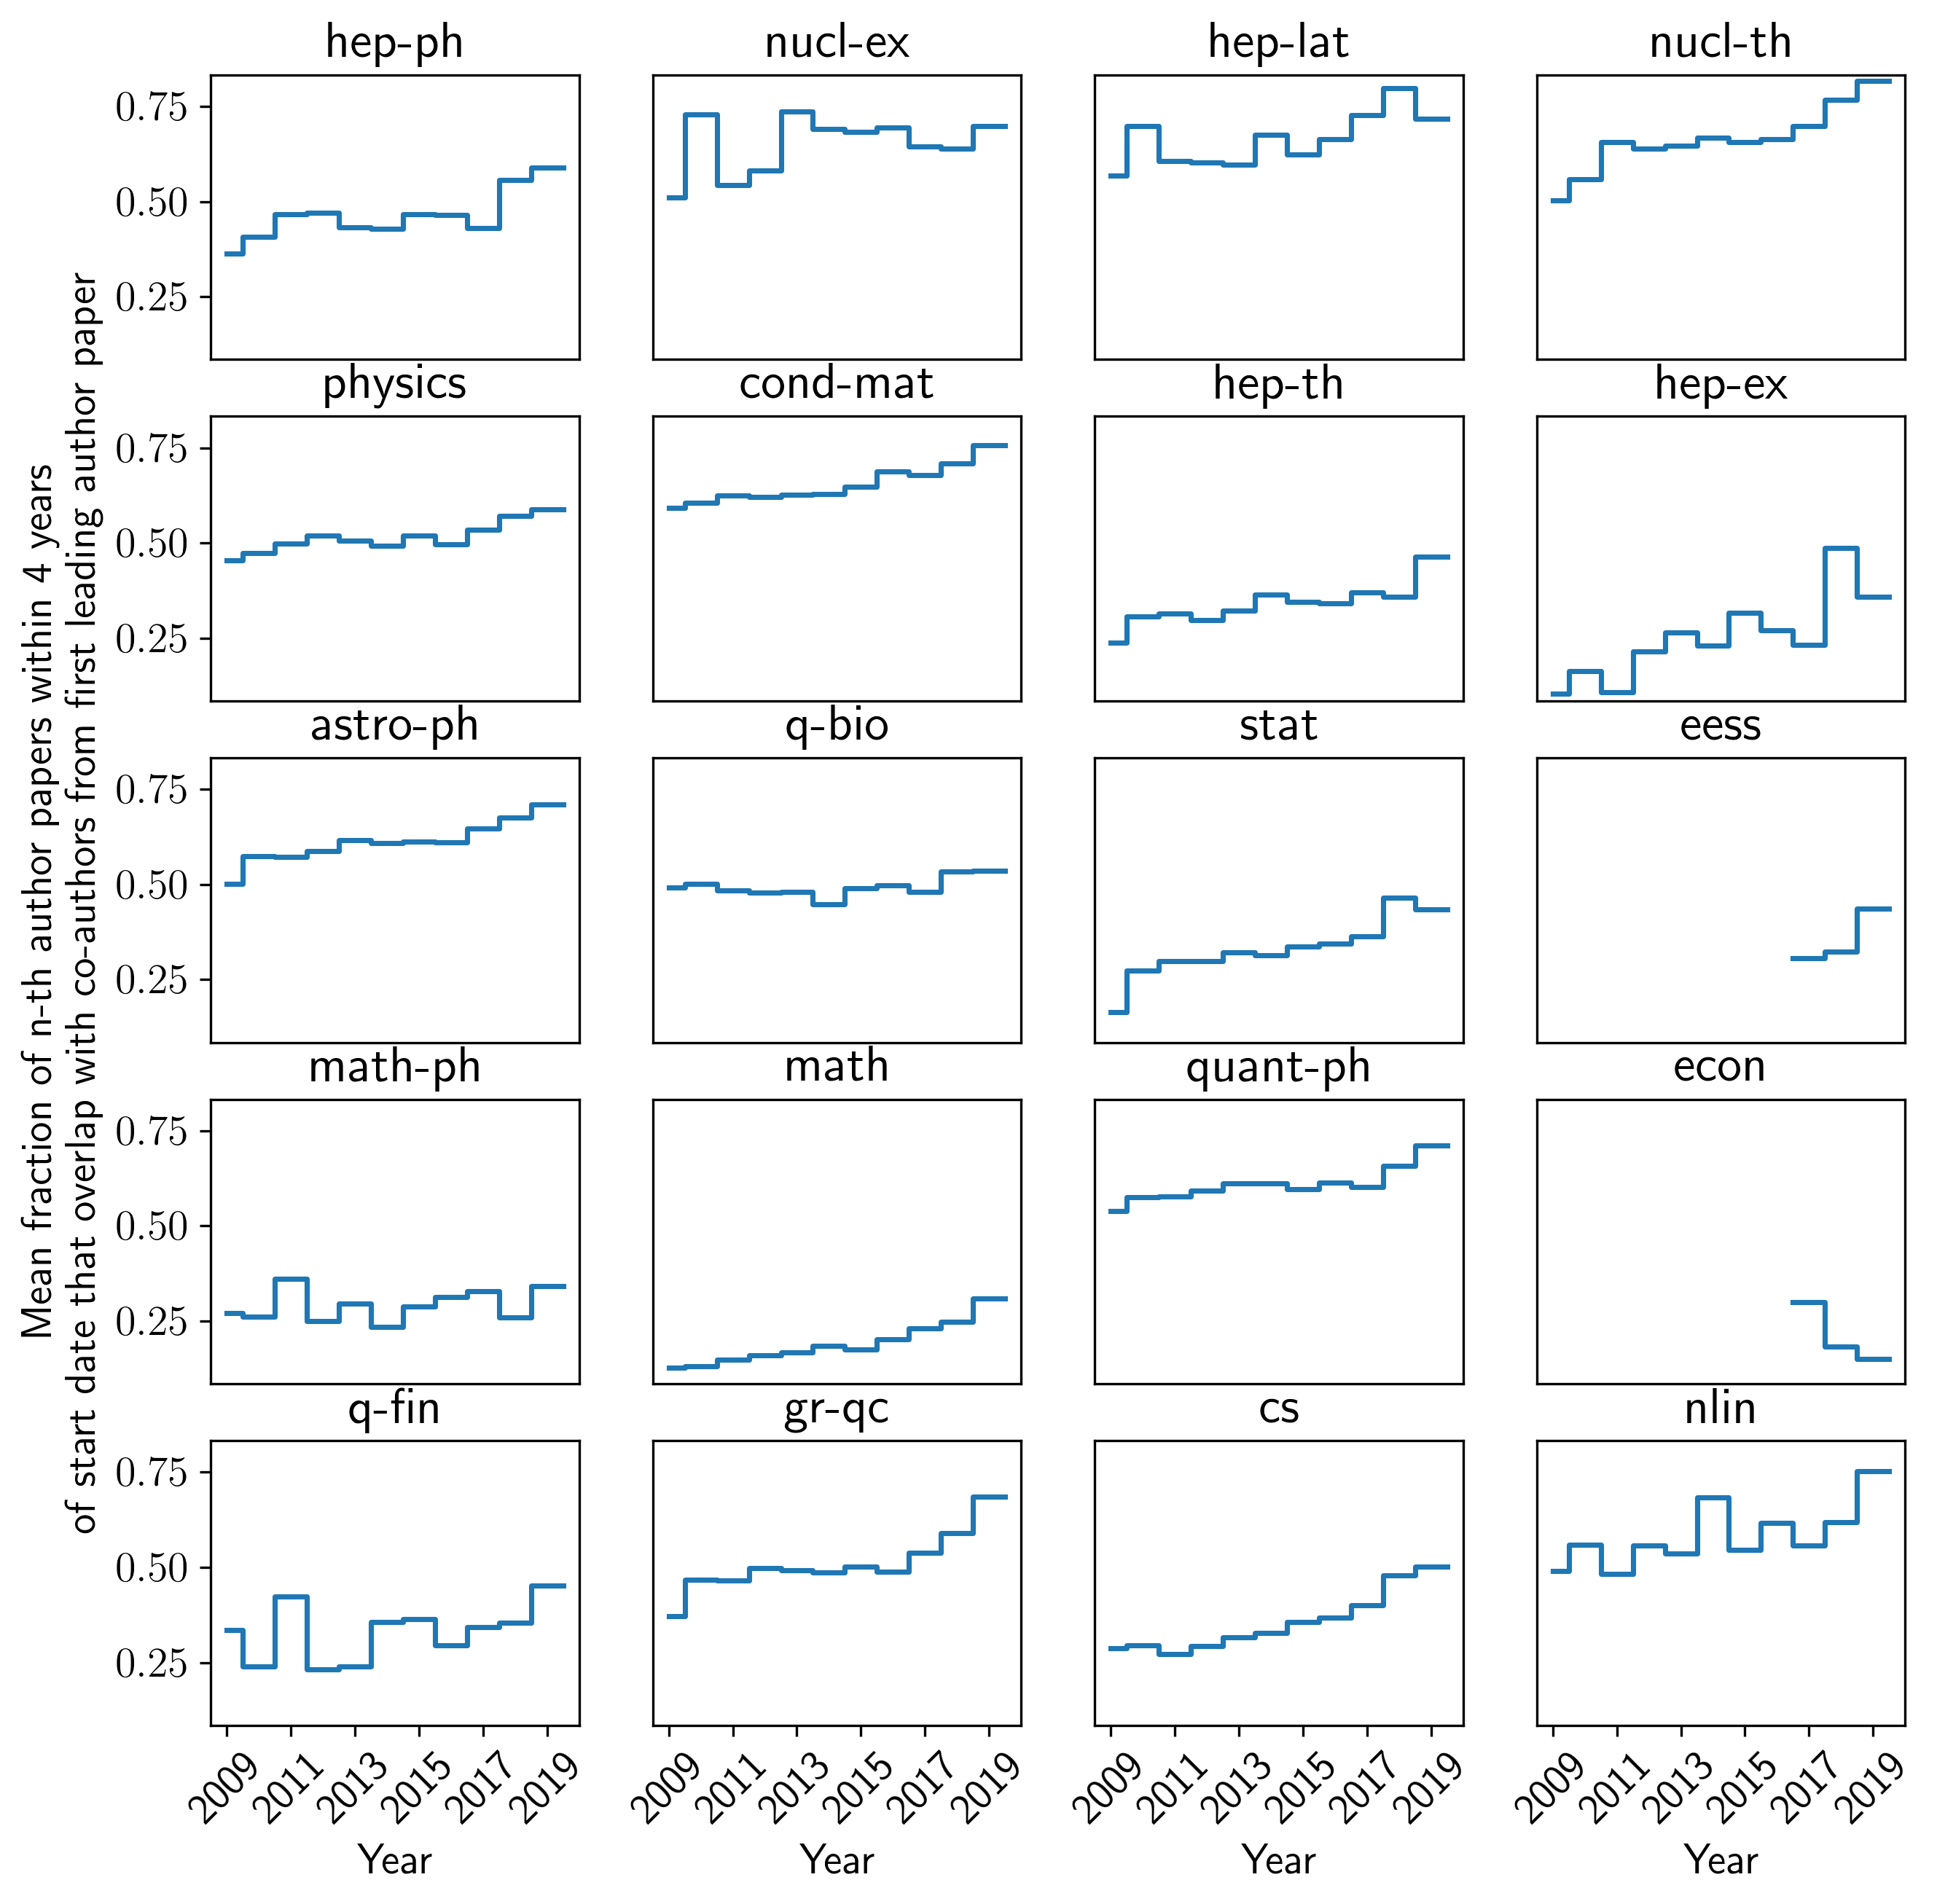

In [42]:
def get_currency(cohort, start_year, end_year, min_papers_per_bin=5):
    
    x = np.array([e["p1_year"] + e["p1_month"]/12. for e in cohort.values()])
    y = np.array([e["ratio_overlap_to_total"] for e in cohort.values()])

    # Calculate some summary value at each.
    xs = np.arange(start_year, end_year + 0.5, 1)
    ys = np.nan * np.ones((xs.size, 2))

    idx = np.digitize(x, xs)

    for i, xs_ in enumerate(xs[:-1]):
        ok = (idx == (i + 1))
        if sum(ok) < min_papers_per_bin:
            continue
            
        ys[i, :] = np.hstack([
            np.nanmedian(y[ok]),
            np.nanmean(y[ok]),
        ])

        # Sanity check because I never trust digitize.
        assert np.all(x[ok] >= xs_) and np.all(xs[i + 1] >= x[ok])
    
    return (xs, ys)

ylim = None

fig, axes = plt.subplots(5, 4)
axes = np.array(axes).flatten()
for i, (ax, ppc) in enumerate(zip(axes, ppcs)):
    xs, ys = get_currency(cohorts[ppc], start_year, end_year)

    ax.plot(xs, ys[:, 1], drawstyle="steps-mid", label="Mean")

    ax.set_xlim(start_year - 0.5, end_year)
    if not ax.is_first_col():
        ax.set_yticks([])
    if not ax.is_last_row():
        ax.set_xticks([])
    else:
        ax.set_xticks(np.arange(start_year, end_year + 1, 2))
        ax.set_xticklabels(ax.get_xticks(), rotation=45)
        ax.set_xlabel(r"Year")
    
    if ylim is not None:
        ax.set_ylim(0, 1)
    ax.set_title(ppc)

fig.axes[2 * 4].set_ylabel(
    f"Mean fraction of n-th author papers within {track_years} years\nof start date that overlap with co-authors from first leading author paper"
)
if ylim is None:
    ylims = np.array([ax.get_ylim() for ax in axes]).flatten()
    ylims = (np.min(ylims), np.max(ylims))
    for ax in axes:
        ax.set_ylim(*ylims)
    
fig.tight_layout()
fig.savefig("author-valuation-all-fields.png", dpi=300)

In [44]:
# Let's do it by primary_category now.
# Build field-specific profiles
pcs = set(records["primary_category"])
profiles_by_category = {}
for pc in pcs:
    mask = (records["primary_category"] == pc)
    profiles_by_category[pc] = get_author_profiles(
        records[mask],
        authors
    )

In [46]:
# Define cohorts.
start_year, end_year, track_years = (2009, 2020, 4)

kwds = dict(track_years=4, ignore=common_names)

cohorts_by_category = {}
for pc in pcs:
    print(pc)
    cohorts_by_category[pc] = get_cohort(profiles_by_category[pc], start_year, end_year, **kwds)

  0%|          | 0/36800 [00:00<?, ?it/s]

cs.SD
stat.OT
math.RT
q-bio.PE
cs.CV


  0%|          | 0/7819 [00:00<?, ?it/s]

hep-lat
cs.CY
q-fin.MF
q-bio.NC


  0%|          | 0/16172 [00:00<?, ?it/s]

q-bio.TO
q-fin.GN
nucl-th
cond-mat.dis-nn
cs.CR


100%|██████████| 2780/2780 [00:00<00:00, 177284.29it/s]

math.MG
physics.class-ph
hep-th
cs.MM



100%|██████████| 1168/1168 [00:00<00:00, 208981.62it/s]

math-ph
q-bio.CB
cs.RO
q-fin.EC
q-fin.CP



  0%|          | 0/21737 [00:00<?, ?it/s]

physics.geo-ph
cs.PF
physics.hist-ph
cs.AI
physics.data-an
q-fin.PM
cond-mat.str-el


  0%|          | 0/1171 [00:00<?, ?it/s]

math.QA
q-bio.GN
math.KT
math.FA
stat.CO
cs.OH
q-bio.SC


  0%|          | 0/22714 [00:00<?, ?it/s]

q-bio.BM
physics.gen-ph
math.AC
cs.ET
hep-ph


 24%|██▍       | 4655/19375 [00:00<00:00, 45389.84it/s]

nucl-ex


  0%|          | 0/14575 [00:00<?, ?it/s]

cs.NI
cs.DC


100%|██████████| 4472/4472 [00:00<00:00, 144641.21it/s]

math.GR
physics.pop-ph
cs.GR
physics.ao-ph
physics.flu-dyn
cs.GL
cs.CG
math.RA



 31%|███       | 5630/18383 [00:00<00:00, 56288.78it/s]

astro-ph
cs.CL


 30%|███       | 11012/36184 [00:00<00:00, 50983.92it/s]

cs.LG


  0%|          | 0/8092 [00:00<?, ?it/s]

cs.LO
nlin.SI
physics.bio-ph
cs.FL
math.CA
cond-mat.quant-gas


  7%|▋         | 1913/26852 [00:00<00:02, 9164.16it/s]

astro-ph.GA


  0%|          | 0/37931 [00:00<?, ?it/s]

econ.GN
math.NT
astro-ph.IM


  0%|          | 0/11735 [00:00<?, ?it/s]

math.GN
stat.ME
q-fin.ST
cond-mat.other
cs.DL
math.PR


  0%|          | 0/25799 [00:00<?, ?it/s]

cond-mat.supr-con
astro-ph.CO


100%|██████████| 17001/17001 [00:00<00:00, 146286.52it/s]

cs.DS
eess.SY
cond-mat.soft



100%|██████████| 6543/6543 [00:00<00:00, 167288.42it/s]

math.AT
math.OA
stat.ML
cs.AR
cs.NE



  0%|          | 0/28318 [00:00<?, ?it/s]

cs.CC
nlin.CD
nlin.PS
physics.acc-ph
math.CV
astro-ph.SR


  0%|          | 0/12959 [00:00<?, ?it/s]

math.DG
cs.GT
eess.IV
math.NA


  0%|          | 0/11855 [00:00<?, ?it/s]

physics.space-ph
econ.TH
math.OC
eess.SP


  0%|          | 0/9743 [00:00<?, ?it/s]

cs.SI
cs.MA
math.SP
nlin.AO
cs.OS
physics.ed-ph
cs.NA
physics.plasm-ph


 10%|▉         | 3823/39026 [00:00<00:00, 37690.69it/s]

q-fin.TR
physics.ins-det


 68%|██████▊   | 9376/13696 [00:00<00:00, 93755.62it/s]

cond-mat.stat-mech
cs.IT


  0%|          | 0/7983 [00:00<?, ?it/s]

math.HO
physics.comp-ph
q-bio.OT
math.GM
math.LO
cs.MS
cs.DB
q-bio.MN
math.ST


 22%|██▏       | 11525/51279 [00:00<00:00, 115246.54it/s]

stat.AP
cond-mat.mtrl-sci


  0%|          | 0/1515 [00:00<?, ?it/s]

physics.optics
math.CT


  0%|          | 0/27394 [00:00<?, ?it/s]

physics.med-ph
math.GT
physics.app-ph
hep-ex


  3%|▎         | 618/18900 [00:00<00:02, 6172.10it/s]

astro-ph.EP


  0%|          | 0/9491 [00:00<?, ?it/s]

physics.atom-ph
physics.atm-clus
cs.IR
econ.EM
q-fin.PR
cs.DM
physics.soc-ph


 25%|██▍       | 9538/38913 [00:00<00:00, 95378.04it/s]

q-fin.RM
cond-mat.mes-hall


  0%|          | 0/32966 [00:00<?, ?it/s]

math.CO
q-bio.QM
quant-ph


  0%|          | 0/16680 [00:00<?, ?it/s]

cs.SC
physics.chem-ph
cs.SE
math.DS
gr-qc


  0%|          | 0/27983 [00:00<?, ?it/s]

cs.CE
cs.PL
math.AG
nlin.CG
math.SG
cs.SY
astro-ph.HE


100%|██████████| 3672/3672 [00:00<00:00, 192067.20it/s]

cs.HC
math.AP
eess.AS


In [53]:
C = 4
# Should use ceil here, but instead I will cut off 1 category!
R = int(np.round(len(cohorts_by_category) / C))
ylim = None

fig, axes = plt.subplots(R, C, figsize=(10, R * 3))

axes = np.array(axes).flatten()
for i, (ax, pc) in enumerate(zip(axes, sorted(pcs))):
    xs, ys = get_currency(cohorts_by_category[pc], start_year, end_year)

    ax.plot(xs, ys[:, 1], drawstyle="steps-mid", label="Mean")

    ax.set_xlim(start_year - 0.5, end_year)
    if not ax.is_first_col():
        ax.set_yticks([])
    if not ax.is_last_row():
        ax.set_xticks([])
    else:
        ax.set_xticks(np.arange(start_year, end_year + 1, 2))
        ax.set_xticklabels(ax.get_xticks(), rotation=45)
        ax.set_xlabel(r"Year")

    if ylim is not None:
        ax.set_ylim(0, 1)
    ax.set_title(pc)

fig.axes[int(R / 2) * C].set_ylabel(
    f"Mean fraction of n-th author papers within {track_years} years\n"
    f"of start date that overlap with co-authors from first leading author paper"
)
if ylim is None:
    ylims = np.array([ax.get_ylim() for ax in axes]).flatten()
    ylims = (np.min(ylims), np.max(ylims))
    for ax in axes:
        ax.set_ylim(*ylims)

#fig.tight_layout()

/Users/arc/anaconda3/envs/cenv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-42-719ed30f3791>:19: RuntimeWarning: Mean of empty slice
  np.nanmean(y[ok]),
/Users/arc/anaconda3/envs/cenv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-42-719ed30f3791>:19: RuntimeWarning: Mean of empty slice
  np.nanmean(y[ok]),
/Users/arc/anaconda3/envs/cenv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-42-719ed30f3791>:19: RuntimeWarning: Mean of empty slice
  np.nanmean(y[ok]),
/Users/arc/anaconda3/envs/cenv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1115: RuntimeWarning:

In [ ]:
'''


def get_inactive_cohort(
        profiles, 
        first_appears=2012.,
        now=2021 + 4/13.,
        years_since=3, 
        max_career_span=5,
        ignore=None,
        **kwargs
    ):
        
    cohort_names = []
    for author_name, profile in tqdm(profiles.items()):
        if len(profile) == 1 or (ignore is not None and author_name in ignore): continue
        
        sorted_profile = sorted(profile, key=sorter)
        
        # Check that the first record appears after some time, so we dont get old people.
        first_pub_date = sorter([sorted_profile[0][0]])
        if first_pub_date <= first_appears:
            continue
            
        last_pub_date = sorter([sorted_profile[-1][0]])
        if (last_pub_date - first_pub_date) > max_career_span:
            continue
        
        # Get most recent first-author paper.        
        for arxiv_id, author_index in sorted_profile[::-1]:
            if author_index == 0:
                pub_date = sorter([arxiv_id])
                if (now - pub_date) >= years_since:
                    #if author_name == "Caranicolas, N.":
                    #    raise a
                    cohort_names.append(author_name)
                    break
        else:
            # No break, so not in our cohort.
            continue

    return cohort_names



def get_active_cohort(
        profiles,
        first_appears=2012.,
        minimum_first_author_papers=1,
        minimum_career_span=8,
        ignore=None,
        **kwargs
    ):
    """
    Return names of people who have remained active over a long time (e.g., faculty).
    """
    cohort_names = []
    for author_name, profile in tqdm(profiles.items()):
        if ignore is not None and author_name in ignore: continue
        sorted_profile = sorted(profile, key=sorter)
        
        # Check that the first record appears after some time, so we dont get old people.
        first_pub_date = sorter([sorted_profile[0][0]])
        if first_pub_date <= first_appears:
            continue
            
        last_pub_date = sorter([sorted_profile[-1][0]])
        if (last_pub_date - first_pub_date) < minimum_career_span:
            continue
            
        # Existing faculty will appear on co-author papers for a decade and never publish first authors
        if minimum_first_author_papers is not None:
            n_first = 0
            for (arxiv_id, author_index) in sorted_profile:
                if author_index == 0:
                    n_first += 1
                
            if n_first >= minimum_first_author_papers:
                cohort_names.append(author_name)
        else:
            cohort_names.append(author_name)
    
    return cohort_names
        
    
max_career_span = 5
kwds = dict(
    first_appears=2010,
    ignore=common_names,
    # For inactive cohort,
    max_career_span=max_career_span,
    years_since=3,
    # For active cohort
    minimum_career_span=10
)
    
inactive_names = get_inactive_cohort(profiles["astro-ph"], **kwds)
active_names = get_active_cohort(profiles["astro-ph"], **kwds)

'''